In [1]:
import os, sys

sys.path.append(os.getcwd())

from torchvision.models.inception import inception_v3
from scipy.stats import entropy

import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import make_swiss_roll

torch.manual_seed(1)
device='cuda'


In [2]:



# generate 2D Swiss Roll data
def Data_gen(batch_size, noise=0.0, scale_factor=0.1):
    
    # generate Swiss Roll data
    data, _ = make_swiss_roll(n_samples=batch_size, noise=noise)
    data_2d = data[:, [0, 2]]  # Take the x and z axes to represent the Swiss Roll in 2D
    
    # apply scaling factor 
    data_2d_scaled = data_2d * scale_factor
    data_2d_scaled = data_2d_scaled.astype('float32')
    
    data_tensor = torch.tensor(data_2d_scaled, device=device)
    
    return data_tensor






In [3]:
class WGANS(nn.Module):
    
    def __init__(self,G_Ns,D_Ns):
        super().__init__()
        
        
        self.G_Ws=[]
        self.G_bs=[]
        
        self.D_Ws=[]
        self.D_bs=[]
        
        
        self.G_Ns=G_Ns
        self.D_Ns=D_Ns
        
        self.leaky_relu_slope = 0.01 #leaky relu
        
        for n in range(1,np.shape(G_Ns)[0]):
        
            self.G_Ws.append(nn.Parameter(torch.randn([G_Ns[n-1], G_Ns[n]], device=device) * 0.02))
            self.G_bs.append(nn.Parameter(torch.zeros([G_Ns[n]], device=device)))
            
        for n in range(1,np.shape(D_Ns)[0]):
        
            self.D_Ws.append(nn.Parameter(torch.randn([D_Ns[n-1], D_Ns[n]], device=device) * 0.02))
            self.D_bs.append(nn.Parameter(torch.zeros([D_Ns[n]], device=device)))
            
    
    
    def Initialise_Hyperparameters(self,eta,lamda):

        self.eta=eta
        
#         self.opt_D=optim.RMSprop(MLP.D_Ws + MLP.D_bs, lr=eta)
#         self.opt_G=optim.RMSprop(MLP.G_Ws + MLP.G_bs, lr=eta)
        self.opt_D=optim.Adam(self.D_Ws+self.D_bs, lr=eta, betas=(0.5, 0.9))
        self.opt_G=optim.Adam(self.G_Ws+self.G_bs, lr=eta, betas=(0.5, 0.9))
        
        self.lamda=lamda
    
    def calc_gradient_penalty(self, real_data, fake_data):
        
        batch_size=real_data.size()[0]
        alpha = torch.rand([batch_size, 1],device=device)

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        interpolates.requires_grad_()

        disc_interpolates = self.Forward_Discriminator(interpolates)

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size(),device=device),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        GP = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lamda
        
        return GP
    
    
        

    
    def Forward_Generator(self, S):
        
        xs=[]
        xs.append(S)
                
        for n in range(0,np.shape(self.G_Ns)[0]-2):
            
            xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.G_Ws[n]),self.G_bs[n]) ) )
            
        y_g=torch.add(torch.matmul(xs[-1],self.G_Ws[-1]),self.G_bs[-1])
        
        return y_g
    
    
    def Forward_Discriminator(self, S):

        xs=[]
        xs.append(S)
                
        for n in range(0,np.shape(self.D_Ns)[0]-2):
            
            xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.D_Ws[n]),self.D_bs[n]) ) )
        
        D=torch.add(torch.matmul(xs[-1],self.D_Ws[-1]),self.D_bs[-1])
        
        return D
    
    def Train_D(self,S,real_data):
        
        with torch.no_grad():
            
            fake_data=self.Forward_Generator(S)
        
        self.opt_D.zero_grad()
        
        D_real=self.Forward_Discriminator(real_data)
        D_real=-D_real.mean()
        D_real.backward()
        
        D_fake=self.Forward_Discriminator(fake_data)
        D_fake=D_fake.mean()
        D_fake.backward()
        
        GP=self.calc_gradient_penalty(real_data,fake_data)
        GP.backward()
        D_cost = (D_fake - D_real + GP).detach() 
#         D_cost = (D_fake - D_real).detach()
        D_W = (D_real - D_fake).detach()
        
        self.opt_D.step()
#         self.weight_clipping(0.01)
        
        return D_cost, D_W, fake_data
        
    def Train_G(self,S):
        
        self.opt_G.zero_grad()
        
        fake_data=self.Forward_Generator(S)
        
        D_fake=self.Forward_Discriminator(fake_data)
        D_fake=-D_fake.mean()
        D_fake.backward()
        
        G_cost=(-D_fake).detach()
        
        self.opt_G.step()
        
        return G_cost, fake_data
    
    
    def weight_clipping(self, clip_value):
        for w in self.D_Ws:
            w.data.clamp_(-clip_value, clip_value)
        for b in self.D_bs:
            b.data.clamp_(-clip_value, clip_value)

    

In [4]:
G_Ns = np.array([2, 512, 512, 512, 2])
D_Ns = np.array([2,512,512,512,1]) 

model = WGANS(G_Ns, D_Ns)
model.to(device)


N_train=100000

D_step=5
eta=0.0001
batch_size=256
lamda=10

MLP=WGANS(G_Ns,D_Ns)
MLP.Initialise_Hyperparameters(eta,lamda)

MSE_D=np.zeros([2,D_step,N_train])
MSE_G=np.zeros([N_train])


def compute_euclidean_distance(real_data, fake_data):
    
    return torch.sqrt(((real_data - fake_data) ** 2).sum(1)).mean().item()



def compute_euclidean_distance(real_data, fake_data):
    
    return torch.sqrt(((real_data - fake_data) ** 2).sum(1)).mean().item()


clip_value = 0.1

for n in range(N_train):
    if n>0:
        for k in range(D_step):

            true_data=Data_gen(batch_size)
            S=torch.randn([batch_size,2],device=device)
            
            D_cost, D_W, fake_data=MLP.Train_D(S, true_data)
            
#             #weight clipping
#             MLP.weight_clipping(clip_value)
            
            MSE_D[0,k,n]=np.copy(np.array(D_W.to('cpu').detach()))
            MSE_D[1,k,n]=np.copy(np.array(D_cost.to('cpu').detach()))
        
        S=torch.randn([batch_size,2],device=device)  
        G_cost, fake_data=MLP.Train_G(S)

        MSE_G[n]=np.copy(np.array(G_cost.to('cpu').detach()))
        
        print("Current iteration: ", n)
        print(D_W)
        print(D_cost)
        print(G_cost)
        
        

        

Current iteration:  1
tensor(7.8978e-05, device='cuda:0')
tensor(-7.8978e-05, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  2
tensor(-6.3676e-05, device='cuda:0')
tensor(6.3676e-05, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  3
tensor(-0.0002, device='cuda:0')
tensor(0.0002, device='cuda:0')
tensor(-0.0007, device='cuda:0')
Current iteration:  4
tensor(-0.0004, device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  5
tensor(-0.0009, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(-0.0025, device='cuda:0')
Current iteration:  6
tensor(-0.0018, device='cuda:0')
tensor(0.0018, device='cuda:0')
tensor(-0.0037, device='cuda:0')
Current iteration:  7
tensor(-0.0035, device='cuda:0')
tensor(0.0035, device='cuda:0')
tensor(-0.0049, device='cuda:0')
Current iteration:  8
tensor(-0.0056, device='cuda:0')
tensor(0.0056, device='cuda:0')
tensor(-0.0062, device='cuda:0')
Current iteration:  9
te

tensor(0.0925, device='cuda:0')
tensor(-0.0166, device='cuda:0')
Current iteration:  80
tensor(-0.0830, device='cuda:0')
tensor(0.0830, device='cuda:0')
tensor(-0.0167, device='cuda:0')
Current iteration:  81
tensor(-0.0888, device='cuda:0')
tensor(0.0888, device='cuda:0')
tensor(-0.0178, device='cuda:0')
Current iteration:  82
tensor(-0.1014, device='cuda:0')
tensor(0.1014, device='cuda:0')
tensor(-0.0158, device='cuda:0')
Current iteration:  83
tensor(-0.0963, device='cuda:0')
tensor(0.0963, device='cuda:0')
tensor(-0.0170, device='cuda:0')
Current iteration:  84
tensor(-0.1007, device='cuda:0')
tensor(0.1007, device='cuda:0')
tensor(-0.0127, device='cuda:0')
Current iteration:  85
tensor(-0.0890, device='cuda:0')
tensor(0.0890, device='cuda:0')
tensor(-0.0131, device='cuda:0')
Current iteration:  86
tensor(-0.1041, device='cuda:0')
tensor(0.1041, device='cuda:0')
tensor(-0.0097, device='cuda:0')
Current iteration:  87
tensor(-0.0997, device='cuda:0')
tensor(0.0997, device='cuda:0')


Current iteration:  155
tensor(0.0429, device='cuda:0')
tensor(-0.0429, device='cuda:0')
tensor(-0.0227, device='cuda:0')
Current iteration:  156
tensor(0.0509, device='cuda:0')
tensor(-0.0509, device='cuda:0')
tensor(-0.0251, device='cuda:0')
Current iteration:  157
tensor(0.0547, device='cuda:0')
tensor(-0.0547, device='cuda:0')
tensor(-0.0277, device='cuda:0')
Current iteration:  158
tensor(0.0601, device='cuda:0')
tensor(-0.0601, device='cuda:0')
tensor(-0.0301, device='cuda:0')
Current iteration:  159
tensor(0.0603, device='cuda:0')
tensor(-0.0603, device='cuda:0')
tensor(-0.0311, device='cuda:0')
Current iteration:  160
tensor(0.0598, device='cuda:0')
tensor(-0.0598, device='cuda:0')
tensor(-0.0317, device='cuda:0')
Current iteration:  161
tensor(0.0596, device='cuda:0')
tensor(-0.0596, device='cuda:0')
tensor(-0.0302, device='cuda:0')
Current iteration:  162
tensor(0.0560, device='cuda:0')
tensor(-0.0560, device='cuda:0')
tensor(-0.0298, device='cuda:0')
Current iteration:  163


Current iteration:  231
tensor(-0.0075, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0035, device='cuda:0')
Current iteration:  232
tensor(-0.0093, device='cuda:0')
tensor(0.0093, device='cuda:0')
tensor(0.0043, device='cuda:0')
Current iteration:  233
tensor(-0.0108, device='cuda:0')
tensor(0.0108, device='cuda:0')
tensor(0.0048, device='cuda:0')
Current iteration:  234
tensor(-0.0113, device='cuda:0')
tensor(0.0113, device='cuda:0')
tensor(0.0049, device='cuda:0')
Current iteration:  235
tensor(-0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0040, device='cuda:0')
Current iteration:  236
tensor(-0.0088, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0036, device='cuda:0')
Current iteration:  237
tensor(-0.0046, device='cuda:0')
tensor(0.0046, device='cuda:0')
tensor(0.0022, device='cuda:0')
Current iteration:  238
tensor(-0.0023, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0004, device='cuda:0')
Current iteration:  239
tensor(0

Current iteration:  304
tensor(-0.0114, device='cuda:0')
tensor(0.0114, device='cuda:0')
tensor(0.0049, device='cuda:0')
Current iteration:  305
tensor(-0.0133, device='cuda:0')
tensor(0.0133, device='cuda:0')
tensor(0.0049, device='cuda:0')
Current iteration:  306
tensor(-0.0068, device='cuda:0')
tensor(0.0068, device='cuda:0')
tensor(0.0013, device='cuda:0')
Current iteration:  307
tensor(-0.0031, device='cuda:0')
tensor(0.0031, device='cuda:0')
tensor(0.0013, device='cuda:0')
Current iteration:  308
tensor(-0.0068, device='cuda:0')
tensor(0.0068, device='cuda:0')
tensor(0.0028, device='cuda:0')
Current iteration:  309
tensor(-0.0099, device='cuda:0')
tensor(0.0099, device='cuda:0')
tensor(0.0033, device='cuda:0')
Current iteration:  310
tensor(-0.0094, device='cuda:0')
tensor(0.0094, device='cuda:0')
tensor(0.0040, device='cuda:0')
Current iteration:  311
tensor(-0.0112, device='cuda:0')
tensor(0.0112, device='cuda:0')
tensor(0.0039, device='cuda:0')
Current iteration:  312
tensor(-

Current iteration:  380
tensor(-0.0190, device='cuda:0')
tensor(0.0190, device='cuda:0')
tensor(0.0092, device='cuda:0')
Current iteration:  381
tensor(-0.0161, device='cuda:0')
tensor(0.0161, device='cuda:0')
tensor(0.0072, device='cuda:0')
Current iteration:  382
tensor(-0.0188, device='cuda:0')
tensor(0.0188, device='cuda:0')
tensor(0.0090, device='cuda:0')
Current iteration:  383
tensor(-0.0145, device='cuda:0')
tensor(0.0145, device='cuda:0')
tensor(0.0059, device='cuda:0')
Current iteration:  384
tensor(-0.0147, device='cuda:0')
tensor(0.0147, device='cuda:0')
tensor(0.0069, device='cuda:0')
Current iteration:  385
tensor(-0.0176, device='cuda:0')
tensor(0.0176, device='cuda:0')
tensor(0.0077, device='cuda:0')
Current iteration:  386
tensor(-0.0210, device='cuda:0')
tensor(0.0210, device='cuda:0')
tensor(0.0090, device='cuda:0')
Current iteration:  387
tensor(-0.0222, device='cuda:0')
tensor(0.0222, device='cuda:0')
tensor(0.0102, device='cuda:0')
Current iteration:  388
tensor(-

Current iteration:  458
tensor(0.0034, device='cuda:0')
tensor(-0.0034, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  459
tensor(-0.0071, device='cuda:0')
tensor(0.0071, device='cuda:0')
tensor(0.0011, device='cuda:0')
Current iteration:  460
tensor(-0.0161, device='cuda:0')
tensor(0.0161, device='cuda:0')
tensor(0.0063, device='cuda:0')
Current iteration:  461
tensor(-0.0104, device='cuda:0')
tensor(0.0104, device='cuda:0')
tensor(0.0058, device='cuda:0')
Current iteration:  462
tensor(-0.0115, device='cuda:0')
tensor(0.0115, device='cuda:0')
tensor(0.0034, device='cuda:0')
Current iteration:  463
tensor(-0.0050, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(-2.0510e-05, device='cuda:0')
Current iteration:  464
tensor(0.0072, device='cuda:0')
tensor(-0.0072, device='cuda:0')
tensor(-0.0041, device='cuda:0')
Current iteration:  465
tensor(0.0175, device='cuda:0')
tensor(-0.0175, device='cuda:0')
tensor(-0.0126, device='cuda:0')
Current iteration:  466


Current iteration:  533
tensor(-0.0197, device='cuda:0')
tensor(0.0197, device='cuda:0')
tensor(0.0119, device='cuda:0')
Current iteration:  534
tensor(-0.0380, device='cuda:0')
tensor(0.0380, device='cuda:0')
tensor(0.0183, device='cuda:0')
Current iteration:  535
tensor(-0.0435, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(0.0200, device='cuda:0')
Current iteration:  536
tensor(-0.0346, device='cuda:0')
tensor(0.0346, device='cuda:0')
tensor(0.0168, device='cuda:0')
Current iteration:  537
tensor(-0.0368, device='cuda:0')
tensor(0.0368, device='cuda:0')
tensor(0.0197, device='cuda:0')
Current iteration:  538
tensor(-0.0292, device='cuda:0')
tensor(0.0292, device='cuda:0')
tensor(0.0120, device='cuda:0')
Current iteration:  539
tensor(-0.0081, device='cuda:0')
tensor(0.0081, device='cuda:0')
tensor(0.0004, device='cuda:0')
Current iteration:  540
tensor(0.0009, device='cuda:0')
tensor(-0.0009, device='cuda:0')
tensor(-0.0031, device='cuda:0')
Current iteration:  541
tensor(

Current iteration:  609
tensor(-0.0180, device='cuda:0')
tensor(0.0180, device='cuda:0')
tensor(0.0080, device='cuda:0')
Current iteration:  610
tensor(-0.0195, device='cuda:0')
tensor(0.0195, device='cuda:0')
tensor(0.0097, device='cuda:0')
Current iteration:  611
tensor(-0.0206, device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(0.0094, device='cuda:0')
Current iteration:  612
tensor(-0.0186, device='cuda:0')
tensor(0.0186, device='cuda:0')
tensor(0.0086, device='cuda:0')
Current iteration:  613
tensor(-0.0171, device='cuda:0')
tensor(0.0171, device='cuda:0')
tensor(0.0058, device='cuda:0')
Current iteration:  614
tensor(-0.0078, device='cuda:0')
tensor(0.0078, device='cuda:0')
tensor(0.0027, device='cuda:0')
Current iteration:  615
tensor(-0.0102, device='cuda:0')
tensor(0.0102, device='cuda:0')
tensor(0.0029, device='cuda:0')
Current iteration:  616
tensor(-0.0222, device='cuda:0')
tensor(0.0222, device='cuda:0')
tensor(0.0089, device='cuda:0')
Current iteration:  617
tensor(-

Current iteration:  683
tensor(-0.0202, device='cuda:0')
tensor(0.0202, device='cuda:0')
tensor(0.0077, device='cuda:0')
Current iteration:  684
tensor(-0.0231, device='cuda:0')
tensor(0.0231, device='cuda:0')
tensor(0.0094, device='cuda:0')
Current iteration:  685
tensor(-0.0216, device='cuda:0')
tensor(0.0216, device='cuda:0')
tensor(0.0075, device='cuda:0')
Current iteration:  686
tensor(-0.0136, device='cuda:0')
tensor(0.0136, device='cuda:0')
tensor(0.0062, device='cuda:0')
Current iteration:  687
tensor(-0.0124, device='cuda:0')
tensor(0.0124, device='cuda:0')
tensor(0.0052, device='cuda:0')
Current iteration:  688
tensor(-0.0079, device='cuda:0')
tensor(0.0079, device='cuda:0')
tensor(0.0023, device='cuda:0')
Current iteration:  689
tensor(-0.0058, device='cuda:0')
tensor(0.0058, device='cuda:0')
tensor(0.0013, device='cuda:0')
Current iteration:  690
tensor(-0.0067, device='cuda:0')
tensor(0.0067, device='cuda:0')
tensor(0.0039, device='cuda:0')
Current iteration:  691
tensor(-

tensor(0.0134, device='cuda:0')
tensor(0.0049, device='cuda:0')
Current iteration:  760
tensor(-0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0005, device='cuda:0')
Current iteration:  761
tensor(-0.0014, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(-7.4065e-05, device='cuda:0')
Current iteration:  762
tensor(0.0062, device='cuda:0')
tensor(-0.0062, device='cuda:0')
tensor(-0.0026, device='cuda:0')
Current iteration:  763
tensor(0.0075, device='cuda:0')
tensor(-0.0075, device='cuda:0')
tensor(-0.0056, device='cuda:0')
Current iteration:  764
tensor(0.0090, device='cuda:0')
tensor(-0.0090, device='cuda:0')
tensor(-0.0049, device='cuda:0')
Current iteration:  765
tensor(-0.0048, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(0.0008, device='cuda:0')
Current iteration:  766
tensor(-0.0091, device='cuda:0')
tensor(0.0091, device='cuda:0')
tensor(0.0044, device='cuda:0')
Current iteration:  767
tensor(-0.0188, device='cuda:0')
tensor(0.0188, device='c

Current iteration:  837
tensor(0.0176, device='cuda:0')
tensor(-0.0176, device='cuda:0')
tensor(-0.0128, device='cuda:0')
Current iteration:  838
tensor(0.0243, device='cuda:0')
tensor(-0.0243, device='cuda:0')
tensor(-0.0147, device='cuda:0')
Current iteration:  839
tensor(0.0190, device='cuda:0')
tensor(-0.0190, device='cuda:0')
tensor(-0.0116, device='cuda:0')
Current iteration:  840
tensor(0.0161, device='cuda:0')
tensor(-0.0161, device='cuda:0')
tensor(-0.0071, device='cuda:0')
Current iteration:  841
tensor(0.0191, device='cuda:0')
tensor(-0.0191, device='cuda:0')
tensor(-0.0102, device='cuda:0')
Current iteration:  842
tensor(0.0231, device='cuda:0')
tensor(-0.0231, device='cuda:0')
tensor(-0.0091, device='cuda:0')
Current iteration:  843
tensor(0.0048, device='cuda:0')
tensor(-0.0048, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  844
tensor(-0.0130, device='cuda:0')
tensor(0.0130, device='cuda:0')
tensor(0.0060, device='cuda:0')
Current iteration:  845
t

tensor(-0.0126, device='cuda:0')
tensor(0.0126, device='cuda:0')
tensor(0.0077, device='cuda:0')
Current iteration:  913
tensor(-0.0352, device='cuda:0')
tensor(0.0352, device='cuda:0')
tensor(0.0166, device='cuda:0')
Current iteration:  914
tensor(-0.0420, device='cuda:0')
tensor(0.0420, device='cuda:0')
tensor(0.0174, device='cuda:0')
Current iteration:  915
tensor(-0.0386, device='cuda:0')
tensor(0.0386, device='cuda:0')
tensor(0.0179, device='cuda:0')
Current iteration:  916
tensor(-0.0389, device='cuda:0')
tensor(0.0389, device='cuda:0')
tensor(0.0176, device='cuda:0')
Current iteration:  917
tensor(-0.0407, device='cuda:0')
tensor(0.0407, device='cuda:0')
tensor(0.0173, device='cuda:0')
Current iteration:  918
tensor(-0.0325, device='cuda:0')
tensor(0.0325, device='cuda:0')
tensor(0.0142, device='cuda:0')
Current iteration:  919
tensor(-0.0115, device='cuda:0')
tensor(0.0115, device='cuda:0')
tensor(0.0027, device='cuda:0')
Current iteration:  920
tensor(0.0093, device='cuda:0')


Current iteration:  982
tensor(0.0286, device='cuda:0')
tensor(-0.0286, device='cuda:0')
tensor(-0.0155, device='cuda:0')
Current iteration:  983
tensor(0.0249, device='cuda:0')
tensor(-0.0249, device='cuda:0')
tensor(-0.0117, device='cuda:0')
Current iteration:  984
tensor(0.0163, device='cuda:0')
tensor(-0.0163, device='cuda:0')
tensor(-0.0086, device='cuda:0')
Current iteration:  985
tensor(-0.0002, device='cuda:0')
tensor(0.0002, device='cuda:0')
tensor(0.0010, device='cuda:0')
Current iteration:  986
tensor(-0.0118, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.0070, device='cuda:0')
Current iteration:  987
tensor(-0.0330, device='cuda:0')
tensor(0.0330, device='cuda:0')
tensor(0.0136, device='cuda:0')
Current iteration:  988
tensor(-0.0372, device='cuda:0')
tensor(0.0372, device='cuda:0')
tensor(0.0154, device='cuda:0')
Current iteration:  989
tensor(-0.0334, device='cuda:0')
tensor(0.0334, device='cuda:0')
tensor(0.0159, device='cuda:0')
Current iteration:  990
tenso

Current iteration:  1055
tensor(-0.0324, device='cuda:0')
tensor(0.0324, device='cuda:0')
tensor(0.0141, device='cuda:0')
Current iteration:  1056
tensor(-0.0152, device='cuda:0')
tensor(0.0152, device='cuda:0')
tensor(0.0055, device='cuda:0')
Current iteration:  1057
tensor(-0.0048, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(0.0017, device='cuda:0')
Current iteration:  1058
tensor(0.0092, device='cuda:0')
tensor(-0.0092, device='cuda:0')
tensor(-0.0094, device='cuda:0')
Current iteration:  1059
tensor(0.0230, device='cuda:0')
tensor(-0.0230, device='cuda:0')
tensor(-0.0136, device='cuda:0')
Current iteration:  1060
tensor(0.0314, device='cuda:0')
tensor(-0.0314, device='cuda:0')
tensor(-0.0149, device='cuda:0')
Current iteration:  1061
tensor(0.0157, device='cuda:0')
tensor(-0.0157, device='cuda:0')
tensor(-0.0068, device='cuda:0')
Current iteration:  1062
tensor(0.0043, device='cuda:0')
tensor(-0.0043, device='cuda:0')
tensor(-0.0034, device='cuda:0')
Current iteration: 

Current iteration:  1125
tensor(0.0248, device='cuda:0')
tensor(-0.0248, device='cuda:0')
tensor(-0.0113, device='cuda:0')
Current iteration:  1126
tensor(0.0130, device='cuda:0')
tensor(-0.0130, device='cuda:0')
tensor(-0.0053, device='cuda:0')
Current iteration:  1127
tensor(-0.0015, device='cuda:0')
tensor(0.0015, device='cuda:0')
tensor(0.0009, device='cuda:0')
Current iteration:  1128
tensor(-0.0046, device='cuda:0')
tensor(0.0046, device='cuda:0')
tensor(0.0020, device='cuda:0')
Current iteration:  1129
tensor(-0.0095, device='cuda:0')
tensor(0.0095, device='cuda:0')
tensor(0.0050, device='cuda:0')
Current iteration:  1130
tensor(-0.0224, device='cuda:0')
tensor(0.0224, device='cuda:0')
tensor(0.0104, device='cuda:0')
Current iteration:  1131
tensor(-0.0353, device='cuda:0')
tensor(0.0353, device='cuda:0')
tensor(0.0168, device='cuda:0')
Current iteration:  1132
tensor(-0.0421, device='cuda:0')
tensor(0.0421, device='cuda:0')
tensor(0.0216, device='cuda:0')
Current iteration:  11

Current iteration:  1192
tensor(0.0080, device='cuda:0')
tensor(-0.0080, device='cuda:0')
tensor(-0.0032, device='cuda:0')
Current iteration:  1193
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0038, device='cuda:0')
Current iteration:  1194
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(0.0006, device='cuda:0')
Current iteration:  1195
tensor(0.0009, device='cuda:0')
tensor(-0.0009, device='cuda:0')
tensor(-0.0023, device='cuda:0')
Current iteration:  1196
tensor(0.0122, device='cuda:0')
tensor(-0.0122, device='cuda:0')
tensor(-0.0052, device='cuda:0')
Current iteration:  1197
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0021, device='cuda:0')
Current iteration:  1198
tensor(-0.0093, device='cuda:0')
tensor(0.0093, device='cuda:0')
tensor(0.0045, device='cuda:0')
Current iteration:  1199
tensor(-0.0242, device='cuda:0')
tensor(0.0242, device='cuda:0')
tensor(0.0127, device='cuda:0')
Current iteration: 

Current iteration:  1269
tensor(0.0150, device='cuda:0')
tensor(-0.0150, device='cuda:0')
tensor(-0.0048, device='cuda:0')
Current iteration:  1270
tensor(-0.0074, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0.0055, device='cuda:0')
Current iteration:  1271
tensor(-0.0182, device='cuda:0')
tensor(0.0182, device='cuda:0')
tensor(0.0106, device='cuda:0')
Current iteration:  1272
tensor(-0.0349, device='cuda:0')
tensor(0.0349, device='cuda:0')
tensor(0.0172, device='cuda:0')
Current iteration:  1273
tensor(-0.0439, device='cuda:0')
tensor(0.0439, device='cuda:0')
tensor(0.0191, device='cuda:0')
Current iteration:  1274
tensor(-0.0348, device='cuda:0')
tensor(0.0348, device='cuda:0')
tensor(0.0172, device='cuda:0')
Current iteration:  1275
tensor(-0.0402, device='cuda:0')
tensor(0.0402, device='cuda:0')
tensor(0.0186, device='cuda:0')
Current iteration:  1276
tensor(-0.0289, device='cuda:0')
tensor(0.0289, device='cuda:0')
tensor(0.0125, device='cuda:0')
Current iteration:  127

Current iteration:  1337
tensor(0.0048, device='cuda:0')
tensor(-0.0048, device='cuda:0')
tensor(-0.0065, device='cuda:0')
Current iteration:  1338
tensor(0.0165, device='cuda:0')
tensor(-0.0165, device='cuda:0')
tensor(-0.0114, device='cuda:0')
Current iteration:  1339
tensor(0.0237, device='cuda:0')
tensor(-0.0237, device='cuda:0')
tensor(-0.0159, device='cuda:0')
Current iteration:  1340
tensor(0.0320, device='cuda:0')
tensor(-0.0320, device='cuda:0')
tensor(-0.0187, device='cuda:0')
Current iteration:  1341
tensor(0.0322, device='cuda:0')
tensor(-0.0322, device='cuda:0')
tensor(-0.0171, device='cuda:0')
Current iteration:  1342
tensor(0.0212, device='cuda:0')
tensor(-0.0212, device='cuda:0')
tensor(-0.0110, device='cuda:0')
Current iteration:  1343
tensor(-0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0024, device='cuda:0')
Current iteration:  1344
tensor(-0.0186, device='cuda:0')
tensor(0.0186, device='cuda:0')
tensor(0.0093, device='cuda:0')
Current iteration:

Current iteration:  1415
tensor(-0.0122, device='cuda:0')
tensor(0.0122, device='cuda:0')
tensor(0.0046, device='cuda:0')
Current iteration:  1416
tensor(-0.0019, device='cuda:0')
tensor(0.0019, device='cuda:0')
tensor(0.0003, device='cuda:0')
Current iteration:  1417
tensor(0.0066, device='cuda:0')
tensor(-0.0066, device='cuda:0')
tensor(-0.0032, device='cuda:0')
Current iteration:  1418
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  1419
tensor(0.0030, device='cuda:0')
tensor(-0.0030, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  1420
tensor(-0.0009, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(0.0011, device='cuda:0')
Current iteration:  1421
tensor(-0.0077, device='cuda:0')
tensor(0.0077, device='cuda:0')
tensor(0.0052, device='cuda:0')
Current iteration:  1422
tensor(-0.0184, device='cuda:0')
tensor(0.0184, device='cuda:0')
tensor(0.0083, device='cuda:0')
Current iteration:  1

Current iteration:  1489
tensor(0.0193, device='cuda:0')
tensor(-0.0193, device='cuda:0')
tensor(-0.0105, device='cuda:0')
Current iteration:  1490
tensor(0.0093, device='cuda:0')
tensor(-0.0093, device='cuda:0')
tensor(-0.0026, device='cuda:0')
Current iteration:  1491
tensor(-0.0125, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0052, device='cuda:0')
Current iteration:  1492
tensor(-0.0375, device='cuda:0')
tensor(0.0375, device='cuda:0')
tensor(0.0141, device='cuda:0')
Current iteration:  1493
tensor(-0.0409, device='cuda:0')
tensor(0.0409, device='cuda:0')
tensor(0.0214, device='cuda:0')
Current iteration:  1494
tensor(-0.0459, device='cuda:0')
tensor(0.0459, device='cuda:0')
tensor(0.0236, device='cuda:0')
Current iteration:  1495
tensor(-0.0516, device='cuda:0')
tensor(0.0516, device='cuda:0')
tensor(0.0224, device='cuda:0')
Current iteration:  1496
tensor(-0.0393, device='cuda:0')
tensor(0.0393, device='cuda:0')
tensor(0.0172, device='cuda:0')
Current iteration:  14

Current iteration:  1559
tensor(0.0968, device='cuda:0')
tensor(-0.0968, device='cuda:0')
tensor(-0.0461, device='cuda:0')
Current iteration:  1560
tensor(0.0845, device='cuda:0')
tensor(-0.0845, device='cuda:0')
tensor(-0.0411, device='cuda:0')
Current iteration:  1561
tensor(0.0782, device='cuda:0')
tensor(-0.0782, device='cuda:0')
tensor(-0.0370, device='cuda:0')
Current iteration:  1562
tensor(0.0711, device='cuda:0')
tensor(-0.0711, device='cuda:0')
tensor(-0.0337, device='cuda:0')
Current iteration:  1563
tensor(0.0620, device='cuda:0')
tensor(-0.0620, device='cuda:0')
tensor(-0.0294, device='cuda:0')
Current iteration:  1564
tensor(0.0526, device='cuda:0')
tensor(-0.0526, device='cuda:0')
tensor(-0.0251, device='cuda:0')
Current iteration:  1565
tensor(0.0337, device='cuda:0')
tensor(-0.0337, device='cuda:0')
tensor(-0.0170, device='cuda:0')
Current iteration:  1566
tensor(0.0194, device='cuda:0')
tensor(-0.0194, device='cuda:0')
tensor(-0.0116, device='cuda:0')
Current iteratio

Current iteration:  1635
tensor(0.0767, device='cuda:0')
tensor(-0.0767, device='cuda:0')
tensor(-0.0394, device='cuda:0')
Current iteration:  1636
tensor(0.0804, device='cuda:0')
tensor(-0.0804, device='cuda:0')
tensor(-0.0365, device='cuda:0')
Current iteration:  1637
tensor(0.0713, device='cuda:0')
tensor(-0.0713, device='cuda:0')
tensor(-0.0347, device='cuda:0')
Current iteration:  1638
tensor(0.0615, device='cuda:0')
tensor(-0.0615, device='cuda:0')
tensor(-0.0299, device='cuda:0')
Current iteration:  1639
tensor(0.0513, device='cuda:0')
tensor(-0.0513, device='cuda:0')
tensor(-0.0243, device='cuda:0')
Current iteration:  1640
tensor(0.0433, device='cuda:0')
tensor(-0.0433, device='cuda:0')
tensor(-0.0203, device='cuda:0')
Current iteration:  1641
tensor(0.0446, device='cuda:0')
tensor(-0.0446, device='cuda:0')
tensor(-0.0218, device='cuda:0')
Current iteration:  1642
tensor(0.0473, device='cuda:0')
tensor(-0.0473, device='cuda:0')
tensor(-0.0228, device='cuda:0')
Current iteratio

Current iteration:  1708
tensor(0.0604, device='cuda:0')
tensor(-0.0604, device='cuda:0')
tensor(-0.0317, device='cuda:0')
Current iteration:  1709
tensor(0.0601, device='cuda:0')
tensor(-0.0601, device='cuda:0')
tensor(-0.0331, device='cuda:0')
Current iteration:  1710
tensor(0.0545, device='cuda:0')
tensor(-0.0545, device='cuda:0')
tensor(-0.0306, device='cuda:0')
Current iteration:  1711
tensor(0.0550, device='cuda:0')
tensor(-0.0550, device='cuda:0')
tensor(-0.0303, device='cuda:0')
Current iteration:  1712
tensor(0.0559, device='cuda:0')
tensor(-0.0559, device='cuda:0')
tensor(-0.0260, device='cuda:0')
Current iteration:  1713
tensor(0.0450, device='cuda:0')
tensor(-0.0450, device='cuda:0')
tensor(-0.0227, device='cuda:0')
Current iteration:  1714
tensor(0.0408, device='cuda:0')
tensor(-0.0408, device='cuda:0')
tensor(-0.0191, device='cuda:0')
Current iteration:  1715
tensor(0.0420, device='cuda:0')
tensor(-0.0420, device='cuda:0')
tensor(-0.0183, device='cuda:0')
Current iteratio

Current iteration:  1776
tensor(0.0202, device='cuda:0')
tensor(-0.0202, device='cuda:0')
tensor(-0.0117, device='cuda:0')
Current iteration:  1777
tensor(0.0361, device='cuda:0')
tensor(-0.0361, device='cuda:0')
tensor(-0.0202, device='cuda:0')
Current iteration:  1778
tensor(0.0492, device='cuda:0')
tensor(-0.0492, device='cuda:0')
tensor(-0.0274, device='cuda:0')
Current iteration:  1779
tensor(0.0471, device='cuda:0')
tensor(-0.0471, device='cuda:0')
tensor(-0.0265, device='cuda:0')
Current iteration:  1780
tensor(0.0539, device='cuda:0')
tensor(-0.0539, device='cuda:0')
tensor(-0.0309, device='cuda:0')
Current iteration:  1781
tensor(0.0628, device='cuda:0')
tensor(-0.0628, device='cuda:0')
tensor(-0.0348, device='cuda:0')
Current iteration:  1782
tensor(0.0627, device='cuda:0')
tensor(-0.0627, device='cuda:0')
tensor(-0.0339, device='cuda:0')
Current iteration:  1783
tensor(0.0627, device='cuda:0')
tensor(-0.0627, device='cuda:0')
tensor(-0.0320, device='cuda:0')
Current iteratio

Current iteration:  1844
tensor(-0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(-0.0024, device='cuda:0')
Current iteration:  1845
tensor(-0.0038, device='cuda:0')
tensor(0.0038, device='cuda:0')
tensor(-0.0019, device='cuda:0')
Current iteration:  1846
tensor(-0.0062, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0041, device='cuda:0')
Current iteration:  1847
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(0.0026, device='cuda:0')
Current iteration:  1848
tensor(-0.0035, device='cuda:0')
tensor(0.0035, device='cuda:0')
tensor(0.0041, device='cuda:0')
Current iteration:  1849
tensor(-0.0024, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  1850
tensor(0.0167, device='cuda:0')
tensor(-0.0167, device='cuda:0')
tensor(-0.0084, device='cuda:0')
Current iteration:  1851
tensor(0.0308, device='cuda:0')
tensor(-0.0308, device='cuda:0')
tensor(-0.0159, device='cuda:0')
Current iteration: 

Current iteration:  1921
tensor(0.0468, device='cuda:0')
tensor(-0.0468, device='cuda:0')
tensor(-0.0234, device='cuda:0')
Current iteration:  1922
tensor(0.0228, device='cuda:0')
tensor(-0.0228, device='cuda:0')
tensor(-0.0104, device='cuda:0')
Current iteration:  1923
tensor(-0.0005, device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor(-0.0030, device='cuda:0')
Current iteration:  1924
tensor(-0.0070, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  1925
tensor(-0.0081, device='cuda:0')
tensor(0.0081, device='cuda:0')
tensor(0.0010, device='cuda:0')
Current iteration:  1926
tensor(-0.0112, device='cuda:0')
tensor(0.0112, device='cuda:0')
tensor(0.0080, device='cuda:0')
Current iteration:  1927
tensor(-0.0092, device='cuda:0')
tensor(0.0092, device='cuda:0')
tensor(0.0046, device='cuda:0')
Current iteration:  1928
tensor(-0.0024, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0016, device='cuda:0')
Current iteration:  

Current iteration:  1998
tensor(-0.0086, device='cuda:0')
tensor(0.0086, device='cuda:0')
tensor(0.0004, device='cuda:0')
Current iteration:  1999
tensor(-0.0160, device='cuda:0')
tensor(0.0160, device='cuda:0')
tensor(0.0084, device='cuda:0')
Current iteration:  2000
tensor(-0.0175, device='cuda:0')
tensor(0.0175, device='cuda:0')
tensor(0.0097, device='cuda:0')
Current iteration:  2001
tensor(-0.0161, device='cuda:0')
tensor(0.0161, device='cuda:0')
tensor(0.0107, device='cuda:0')
Current iteration:  2002
tensor(-0.0081, device='cuda:0')
tensor(0.0081, device='cuda:0')
tensor(0.0073, device='cuda:0')
Current iteration:  2003
tensor(0.0047, device='cuda:0')
tensor(-0.0047, device='cuda:0')
tensor(-0.0023, device='cuda:0')
Current iteration:  2004
tensor(0.0245, device='cuda:0')
tensor(-0.0245, device='cuda:0')
tensor(-0.0142, device='cuda:0')
Current iteration:  2005
tensor(0.0487, device='cuda:0')
tensor(-0.0487, device='cuda:0')
tensor(-0.0277, device='cuda:0')
Current iteration:  2

Current iteration:  2074
tensor(-0.0241, device='cuda:0')
tensor(0.0241, device='cuda:0')
tensor(0.0092, device='cuda:0')
Current iteration:  2075
tensor(-0.0106, device='cuda:0')
tensor(0.0106, device='cuda:0')
tensor(0.0068, device='cuda:0')
Current iteration:  2076
tensor(-0.0088, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0018, device='cuda:0')
Current iteration:  2077
tensor(0.0162, device='cuda:0')
tensor(-0.0162, device='cuda:0')
tensor(-0.0094, device='cuda:0')
Current iteration:  2078
tensor(0.0359, device='cuda:0')
tensor(-0.0359, device='cuda:0')
tensor(-0.0196, device='cuda:0')
Current iteration:  2079
tensor(0.0594, device='cuda:0')
tensor(-0.0594, device='cuda:0')
tensor(-0.0324, device='cuda:0')
Current iteration:  2080
tensor(0.0820, device='cuda:0')
tensor(-0.0820, device='cuda:0')
tensor(-0.0425, device='cuda:0')
Current iteration:  2081
tensor(0.0796, device='cuda:0')
tensor(-0.0796, device='cuda:0')
tensor(-0.0417, device='cuda:0')
Current iteration: 

Current iteration:  2149
tensor(0.0754, device='cuda:0')
tensor(-0.0754, device='cuda:0')
tensor(-0.0394, device='cuda:0')
Current iteration:  2150
tensor(0.0820, device='cuda:0')
tensor(-0.0820, device='cuda:0')
tensor(-0.0439, device='cuda:0')
Current iteration:  2151
tensor(0.0814, device='cuda:0')
tensor(-0.0814, device='cuda:0')
tensor(-0.0450, device='cuda:0')
Current iteration:  2152
tensor(0.0841, device='cuda:0')
tensor(-0.0841, device='cuda:0')
tensor(-0.0444, device='cuda:0')
Current iteration:  2153
tensor(0.0850, device='cuda:0')
tensor(-0.0850, device='cuda:0')
tensor(-0.0442, device='cuda:0')
Current iteration:  2154
tensor(0.0826, device='cuda:0')
tensor(-0.0826, device='cuda:0')
tensor(-0.0408, device='cuda:0')
Current iteration:  2155
tensor(0.0792, device='cuda:0')
tensor(-0.0792, device='cuda:0')
tensor(-0.0395, device='cuda:0')
Current iteration:  2156
tensor(0.0796, device='cuda:0')
tensor(-0.0796, device='cuda:0')
tensor(-0.0358, device='cuda:0')
Current iteratio

Current iteration:  2225
tensor(0.0837, device='cuda:0')
tensor(-0.0837, device='cuda:0')
tensor(-0.0441, device='cuda:0')
Current iteration:  2226
tensor(0.1013, device='cuda:0')
tensor(-0.1013, device='cuda:0')
tensor(-0.0547, device='cuda:0')
Current iteration:  2227
tensor(0.1197, device='cuda:0')
tensor(-0.1197, device='cuda:0')
tensor(-0.0612, device='cuda:0')
Current iteration:  2228
tensor(0.1220, device='cuda:0')
tensor(-0.1220, device='cuda:0')
tensor(-0.0627, device='cuda:0')
Current iteration:  2229
tensor(0.1184, device='cuda:0')
tensor(-0.1184, device='cuda:0')
tensor(-0.0605, device='cuda:0')
Current iteration:  2230
tensor(0.1152, device='cuda:0')
tensor(-0.1152, device='cuda:0')
tensor(-0.0601, device='cuda:0')
Current iteration:  2231
tensor(0.1237, device='cuda:0')
tensor(-0.1237, device='cuda:0')
tensor(-0.0595, device='cuda:0')
Current iteration:  2232
tensor(0.1159, device='cuda:0')
tensor(-0.1159, device='cuda:0')
tensor(-0.0574, device='cuda:0')
Current iteratio

Current iteration:  2302
tensor(0.0774, device='cuda:0')
tensor(-0.0774, device='cuda:0')
tensor(-0.0421, device='cuda:0')
Current iteration:  2303
tensor(0.0790, device='cuda:0')
tensor(-0.0790, device='cuda:0')
tensor(-0.0430, device='cuda:0')
Current iteration:  2304
tensor(0.0774, device='cuda:0')
tensor(-0.0774, device='cuda:0')
tensor(-0.0460, device='cuda:0')
Current iteration:  2305
tensor(0.0856, device='cuda:0')
tensor(-0.0856, device='cuda:0')
tensor(-0.0431, device='cuda:0')
Current iteration:  2306
tensor(0.0832, device='cuda:0')
tensor(-0.0832, device='cuda:0')
tensor(-0.0411, device='cuda:0')
Current iteration:  2307
tensor(0.0827, device='cuda:0')
tensor(-0.0827, device='cuda:0')
tensor(-0.0407, device='cuda:0')
Current iteration:  2308
tensor(0.0734, device='cuda:0')
tensor(-0.0734, device='cuda:0')
tensor(-0.0348, device='cuda:0')
Current iteration:  2309
tensor(0.0672, device='cuda:0')
tensor(-0.0672, device='cuda:0')
tensor(-0.0311, device='cuda:0')
Current iteratio

Current iteration:  2378
tensor(0.0690, device='cuda:0')
tensor(-0.0690, device='cuda:0')
tensor(-0.0342, device='cuda:0')
Current iteration:  2379
tensor(0.0649, device='cuda:0')
tensor(-0.0649, device='cuda:0')
tensor(-0.0334, device='cuda:0')
Current iteration:  2380
tensor(0.0594, device='cuda:0')
tensor(-0.0594, device='cuda:0')
tensor(-0.0302, device='cuda:0')
Current iteration:  2381
tensor(0.0435, device='cuda:0')
tensor(-0.0435, device='cuda:0')
tensor(-0.0215, device='cuda:0')
Current iteration:  2382
tensor(0.0231, device='cuda:0')
tensor(-0.0231, device='cuda:0')
tensor(-0.0110, device='cuda:0')
Current iteration:  2383
tensor(0.0070, device='cuda:0')
tensor(-0.0070, device='cuda:0')
tensor(-0.0044, device='cuda:0')
Current iteration:  2384
tensor(-0.0024, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0024, device='cuda:0')
Current iteration:  2385
tensor(-0.0198, device='cuda:0')
tensor(0.0198, device='cuda:0')
tensor(0.0089, device='cuda:0')
Current iteration:

Current iteration:  2454
tensor(0.0489, device='cuda:0')
tensor(-0.0489, device='cuda:0')
tensor(-0.0251, device='cuda:0')
Current iteration:  2455
tensor(0.0261, device='cuda:0')
tensor(-0.0261, device='cuda:0')
tensor(-0.0142, device='cuda:0')
Current iteration:  2456
tensor(0.0092, device='cuda:0')
tensor(-0.0092, device='cuda:0')
tensor(-0.0057, device='cuda:0')
Current iteration:  2457
tensor(-0.0035, device='cuda:0')
tensor(0.0035, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  2458
tensor(-0.0052, device='cuda:0')
tensor(0.0052, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  2459
tensor(-0.0091, device='cuda:0')
tensor(0.0091, device='cuda:0')
tensor(0.0023, device='cuda:0')
Current iteration:  2460
tensor(-0.0119, device='cuda:0')
tensor(0.0119, device='cuda:0')
tensor(0.0047, device='cuda:0')
Current iteration:  2461
tensor(-0.0021, device='cuda:0')
tensor(0.0021, device='cuda:0')
tensor(0.0019, device='cuda:0')
Current iteration: 

Current iteration:  2529
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0019, device='cuda:0')
Current iteration:  2530
tensor(0.0146, device='cuda:0')
tensor(-0.0146, device='cuda:0')
tensor(-0.0104, device='cuda:0')
Current iteration:  2531
tensor(0.0371, device='cuda:0')
tensor(-0.0371, device='cuda:0')
tensor(-0.0218, device='cuda:0')
Current iteration:  2532
tensor(0.0563, device='cuda:0')
tensor(-0.0563, device='cuda:0')
tensor(-0.0325, device='cuda:0')
Current iteration:  2533
tensor(0.0607, device='cuda:0')
tensor(-0.0607, device='cuda:0')
tensor(-0.0349, device='cuda:0')
Current iteration:  2534
tensor(0.0563, device='cuda:0')
tensor(-0.0563, device='cuda:0')
tensor(-0.0335, device='cuda:0')
Current iteration:  2535
tensor(0.0659, device='cuda:0')
tensor(-0.0659, device='cuda:0')
tensor(-0.0372, device='cuda:0')
Current iteration:  2536
tensor(0.0667, device='cuda:0')
tensor(-0.0667, device='cuda:0')
tensor(-0.0353, device='cuda:0')
Current iteratio

Current iteration:  2600
tensor(0.0343, device='cuda:0')
tensor(-0.0343, device='cuda:0')
tensor(-0.0162, device='cuda:0')
Current iteration:  2601
tensor(0.0336, device='cuda:0')
tensor(-0.0336, device='cuda:0')
tensor(-0.0174, device='cuda:0')
Current iteration:  2602
tensor(0.0314, device='cuda:0')
tensor(-0.0314, device='cuda:0')
tensor(-0.0164, device='cuda:0')
Current iteration:  2603
tensor(0.0305, device='cuda:0')
tensor(-0.0305, device='cuda:0')
tensor(-0.0159, device='cuda:0')
Current iteration:  2604
tensor(0.0353, device='cuda:0')
tensor(-0.0353, device='cuda:0')
tensor(-0.0197, device='cuda:0')
Current iteration:  2605
tensor(0.0358, device='cuda:0')
tensor(-0.0358, device='cuda:0')
tensor(-0.0188, device='cuda:0')
Current iteration:  2606
tensor(0.0367, device='cuda:0')
tensor(-0.0367, device='cuda:0')
tensor(-0.0197, device='cuda:0')
Current iteration:  2607
tensor(0.0376, device='cuda:0')
tensor(-0.0376, device='cuda:0')
tensor(-0.0198, device='cuda:0')
Current iteratio

Current iteration:  2672
tensor(0.0290, device='cuda:0')
tensor(-0.0290, device='cuda:0')
tensor(-0.0149, device='cuda:0')
Current iteration:  2673
tensor(0.0268, device='cuda:0')
tensor(-0.0268, device='cuda:0')
tensor(-0.0134, device='cuda:0')
Current iteration:  2674
tensor(0.0237, device='cuda:0')
tensor(-0.0237, device='cuda:0')
tensor(-0.0110, device='cuda:0')
Current iteration:  2675
tensor(0.0147, device='cuda:0')
tensor(-0.0147, device='cuda:0')
tensor(-0.0089, device='cuda:0')
Current iteration:  2676
tensor(0.0134, device='cuda:0')
tensor(-0.0134, device='cuda:0')
tensor(-0.0066, device='cuda:0')
Current iteration:  2677
tensor(0.0118, device='cuda:0')
tensor(-0.0118, device='cuda:0')
tensor(-0.0064, device='cuda:0')
Current iteration:  2678
tensor(0.0129, device='cuda:0')
tensor(-0.0129, device='cuda:0')
tensor(-0.0078, device='cuda:0')
Current iteration:  2679
tensor(0.0182, device='cuda:0')
tensor(-0.0182, device='cuda:0')
tensor(-0.0113, device='cuda:0')
Current iteratio

Current iteration:  2741
tensor(0.0342, device='cuda:0')
tensor(-0.0342, device='cuda:0')
tensor(-0.0161, device='cuda:0')
Current iteration:  2742
tensor(0.0351, device='cuda:0')
tensor(-0.0351, device='cuda:0')
tensor(-0.0168, device='cuda:0')
Current iteration:  2743
tensor(0.0348, device='cuda:0')
tensor(-0.0348, device='cuda:0')
tensor(-0.0188, device='cuda:0')
Current iteration:  2744
tensor(0.0264, device='cuda:0')
tensor(-0.0264, device='cuda:0')
tensor(-0.0158, device='cuda:0')
Current iteration:  2745
tensor(0.0240, device='cuda:0')
tensor(-0.0240, device='cuda:0')
tensor(-0.0136, device='cuda:0')
Current iteration:  2746
tensor(0.0173, device='cuda:0')
tensor(-0.0173, device='cuda:0')
tensor(-0.0080, device='cuda:0')
Current iteration:  2747
tensor(0.0182, device='cuda:0')
tensor(-0.0182, device='cuda:0')
tensor(-0.0117, device='cuda:0')
Current iteration:  2748
tensor(0.0274, device='cuda:0')
tensor(-0.0274, device='cuda:0')
tensor(-0.0137, device='cuda:0')
Current iteratio

tensor(0.0288, device='cuda:0')
tensor(-0.0288, device='cuda:0')
tensor(-0.0146, device='cuda:0')
Current iteration:  2814
tensor(0.0252, device='cuda:0')
tensor(-0.0252, device='cuda:0')
tensor(-0.0135, device='cuda:0')
Current iteration:  2815
tensor(0.0173, device='cuda:0')
tensor(-0.0173, device='cuda:0')
tensor(-0.0078, device='cuda:0')
Current iteration:  2816
tensor(0.0094, device='cuda:0')
tensor(-0.0094, device='cuda:0')
tensor(-0.0058, device='cuda:0')
Current iteration:  2817
tensor(0.0147, device='cuda:0')
tensor(-0.0147, device='cuda:0')
tensor(-0.0073, device='cuda:0')
Current iteration:  2818
tensor(0.0219, device='cuda:0')
tensor(-0.0219, device='cuda:0')
tensor(-0.0116, device='cuda:0')
Current iteration:  2819
tensor(0.0265, device='cuda:0')
tensor(-0.0265, device='cuda:0')
tensor(-0.0166, device='cuda:0')
Current iteration:  2820
tensor(0.0316, device='cuda:0')
tensor(-0.0316, device='cuda:0')
tensor(-0.0154, device='cuda:0')
Current iteration:  2821
tensor(0.0284, d

Current iteration:  2889
tensor(0.0534, device='cuda:0')
tensor(-0.0534, device='cuda:0')
tensor(-0.0256, device='cuda:0')
Current iteration:  2890
tensor(0.0459, device='cuda:0')
tensor(-0.0459, device='cuda:0')
tensor(-0.0210, device='cuda:0')
Current iteration:  2891
tensor(0.0347, device='cuda:0')
tensor(-0.0347, device='cuda:0')
tensor(-0.0140, device='cuda:0')
Current iteration:  2892
tensor(0.0238, device='cuda:0')
tensor(-0.0238, device='cuda:0')
tensor(-0.0138, device='cuda:0')
Current iteration:  2893
tensor(0.0218, device='cuda:0')
tensor(-0.0218, device='cuda:0')
tensor(-0.0103, device='cuda:0')
Current iteration:  2894
tensor(0.0173, device='cuda:0')
tensor(-0.0173, device='cuda:0')
tensor(-0.0095, device='cuda:0')
Current iteration:  2895
tensor(0.0290, device='cuda:0')
tensor(-0.0290, device='cuda:0')
tensor(-0.0173, device='cuda:0')
Current iteration:  2896
tensor(0.0331, device='cuda:0')
tensor(-0.0331, device='cuda:0')
tensor(-0.0192, device='cuda:0')
Current iteratio

Current iteration:  2962
tensor(0.0467, device='cuda:0')
tensor(-0.0467, device='cuda:0')
tensor(-0.0230, device='cuda:0')
Current iteration:  2963
tensor(0.0416, device='cuda:0')
tensor(-0.0416, device='cuda:0')
tensor(-0.0213, device='cuda:0')
Current iteration:  2964
tensor(0.0427, device='cuda:0')
tensor(-0.0427, device='cuda:0')
tensor(-0.0232, device='cuda:0')
Current iteration:  2965
tensor(0.0413, device='cuda:0')
tensor(-0.0413, device='cuda:0')
tensor(-0.0224, device='cuda:0')
Current iteration:  2966
tensor(0.0444, device='cuda:0')
tensor(-0.0444, device='cuda:0')
tensor(-0.0254, device='cuda:0')
Current iteration:  2967
tensor(0.0436, device='cuda:0')
tensor(-0.0436, device='cuda:0')
tensor(-0.0246, device='cuda:0')
Current iteration:  2968
tensor(0.0506, device='cuda:0')
tensor(-0.0506, device='cuda:0')
tensor(-0.0246, device='cuda:0')
Current iteration:  2969
tensor(0.0448, device='cuda:0')
tensor(-0.0448, device='cuda:0')
tensor(-0.0216, device='cuda:0')
Current iteratio

tensor(0.0482, device='cuda:0')
tensor(-0.0482, device='cuda:0')
tensor(-0.0243, device='cuda:0')
Current iteration:  3037
tensor(0.0433, device='cuda:0')
tensor(-0.0433, device='cuda:0')
tensor(-0.0206, device='cuda:0')
Current iteration:  3038
tensor(0.0408, device='cuda:0')
tensor(-0.0408, device='cuda:0')
tensor(-0.0216, device='cuda:0')
Current iteration:  3039
tensor(0.0364, device='cuda:0')
tensor(-0.0364, device='cuda:0')
tensor(-0.0180, device='cuda:0')
Current iteration:  3040
tensor(0.0323, device='cuda:0')
tensor(-0.0323, device='cuda:0')
tensor(-0.0174, device='cuda:0')
Current iteration:  3041
tensor(0.0312, device='cuda:0')
tensor(-0.0312, device='cuda:0')
tensor(-0.0163, device='cuda:0')
Current iteration:  3042
tensor(0.0328, device='cuda:0')
tensor(-0.0328, device='cuda:0')
tensor(-0.0178, device='cuda:0')
Current iteration:  3043
tensor(0.0322, device='cuda:0')
tensor(-0.0322, device='cuda:0')
tensor(-0.0188, device='cuda:0')
Current iteration:  3044
tensor(0.0334, d

Current iteration:  3108
tensor(0.0324, device='cuda:0')
tensor(-0.0324, device='cuda:0')
tensor(-0.0165, device='cuda:0')
Current iteration:  3109
tensor(0.0317, device='cuda:0')
tensor(-0.0317, device='cuda:0')
tensor(-0.0196, device='cuda:0')
Current iteration:  3110
tensor(0.0365, device='cuda:0')
tensor(-0.0365, device='cuda:0')
tensor(-0.0198, device='cuda:0')
Current iteration:  3111
tensor(0.0342, device='cuda:0')
tensor(-0.0342, device='cuda:0')
tensor(-0.0182, device='cuda:0')
Current iteration:  3112
tensor(0.0425, device='cuda:0')
tensor(-0.0425, device='cuda:0')
tensor(-0.0193, device='cuda:0')
Current iteration:  3113
tensor(0.0382, device='cuda:0')
tensor(-0.0382, device='cuda:0')
tensor(-0.0183, device='cuda:0')
Current iteration:  3114
tensor(0.0404, device='cuda:0')
tensor(-0.0404, device='cuda:0')
tensor(-0.0196, device='cuda:0')
Current iteration:  3115
tensor(0.0484, device='cuda:0')
tensor(-0.0484, device='cuda:0')
tensor(-0.0255, device='cuda:0')
Current iteratio

Current iteration:  3186
tensor(0.0136, device='cuda:0')
tensor(-0.0136, device='cuda:0')
tensor(-0.0080, device='cuda:0')
Current iteration:  3187
tensor(0.0138, device='cuda:0')
tensor(-0.0138, device='cuda:0')
tensor(-0.0066, device='cuda:0')
Current iteration:  3188
tensor(0.0174, device='cuda:0')
tensor(-0.0174, device='cuda:0')
tensor(-0.0122, device='cuda:0')
Current iteration:  3189
tensor(0.0272, device='cuda:0')
tensor(-0.0272, device='cuda:0')
tensor(-0.0158, device='cuda:0')
Current iteration:  3190
tensor(0.0268, device='cuda:0')
tensor(-0.0268, device='cuda:0')
tensor(-0.0184, device='cuda:0')
Current iteration:  3191
tensor(0.0315, device='cuda:0')
tensor(-0.0315, device='cuda:0')
tensor(-0.0186, device='cuda:0')
Current iteration:  3192
tensor(0.0313, device='cuda:0')
tensor(-0.0313, device='cuda:0')
tensor(-0.0185, device='cuda:0')
Current iteration:  3193
tensor(0.0303, device='cuda:0')
tensor(-0.0303, device='cuda:0')
tensor(-0.0178, device='cuda:0')
Current iteratio

Current iteration:  3257
tensor(0.0338, device='cuda:0')
tensor(-0.0338, device='cuda:0')
tensor(-0.0182, device='cuda:0')
Current iteration:  3258
tensor(0.0347, device='cuda:0')
tensor(-0.0347, device='cuda:0')
tensor(-0.0163, device='cuda:0')
Current iteration:  3259
tensor(0.0292, device='cuda:0')
tensor(-0.0292, device='cuda:0')
tensor(-0.0136, device='cuda:0')
Current iteration:  3260
tensor(0.0282, device='cuda:0')
tensor(-0.0282, device='cuda:0')
tensor(-0.0135, device='cuda:0')
Current iteration:  3261
tensor(0.0195, device='cuda:0')
tensor(-0.0195, device='cuda:0')
tensor(-0.0137, device='cuda:0')
Current iteration:  3262
tensor(0.0151, device='cuda:0')
tensor(-0.0151, device='cuda:0')
tensor(-0.0074, device='cuda:0')
Current iteration:  3263
tensor(0.0121, device='cuda:0')
tensor(-0.0121, device='cuda:0')
tensor(-0.0049, device='cuda:0')
Current iteration:  3264
tensor(0.0061, device='cuda:0')
tensor(-0.0061, device='cuda:0')
tensor(-0.0029, device='cuda:0')
Current iteratio

Current iteration:  3328
tensor(0.0234, device='cuda:0')
tensor(-0.0234, device='cuda:0')
tensor(-0.0128, device='cuda:0')
Current iteration:  3329
tensor(0.0155, device='cuda:0')
tensor(-0.0155, device='cuda:0')
tensor(-0.0132, device='cuda:0')
Current iteration:  3330
tensor(0.0215, device='cuda:0')
tensor(-0.0215, device='cuda:0')
tensor(-0.0093, device='cuda:0')
Current iteration:  3331
tensor(0.0188, device='cuda:0')
tensor(-0.0188, device='cuda:0')
tensor(-0.0064, device='cuda:0')
Current iteration:  3332
tensor(0.0202, device='cuda:0')
tensor(-0.0202, device='cuda:0')
tensor(-0.0081, device='cuda:0')
Current iteration:  3333
tensor(0.0145, device='cuda:0')
tensor(-0.0145, device='cuda:0')
tensor(-0.0082, device='cuda:0')
Current iteration:  3334
tensor(0.0176, device='cuda:0')
tensor(-0.0176, device='cuda:0')
tensor(-0.0071, device='cuda:0')
Current iteration:  3335
tensor(0.0208, device='cuda:0')
tensor(-0.0208, device='cuda:0')
tensor(-0.0105, device='cuda:0')
Current iteratio

Current iteration:  3405
tensor(0.0132, device='cuda:0')
tensor(-0.0132, device='cuda:0')
tensor(-0.0091, device='cuda:0')
Current iteration:  3406
tensor(0.0197, device='cuda:0')
tensor(-0.0197, device='cuda:0')
tensor(-0.0125, device='cuda:0')
Current iteration:  3407
tensor(0.0194, device='cuda:0')
tensor(-0.0194, device='cuda:0')
tensor(-0.0149, device='cuda:0')
Current iteration:  3408
tensor(0.0224, device='cuda:0')
tensor(-0.0224, device='cuda:0')
tensor(-0.0154, device='cuda:0')
Current iteration:  3409
tensor(0.0237, device='cuda:0')
tensor(-0.0237, device='cuda:0')
tensor(-0.0105, device='cuda:0')
Current iteration:  3410
tensor(0.0221, device='cuda:0')
tensor(-0.0221, device='cuda:0')
tensor(-0.0126, device='cuda:0')
Current iteration:  3411
tensor(0.0202, device='cuda:0')
tensor(-0.0202, device='cuda:0')
tensor(-0.0102, device='cuda:0')
Current iteration:  3412
tensor(0.0180, device='cuda:0')
tensor(-0.0180, device='cuda:0')
tensor(-0.0098, device='cuda:0')
Current iteratio

Current iteration:  3483
tensor(-0.0390, device='cuda:0')
tensor(0.0390, device='cuda:0')
tensor(0.0192, device='cuda:0')
Current iteration:  3484
tensor(-0.0357, device='cuda:0')
tensor(0.0357, device='cuda:0')
tensor(0.0194, device='cuda:0')
Current iteration:  3485
tensor(-0.0342, device='cuda:0')
tensor(0.0342, device='cuda:0')
tensor(0.0168, device='cuda:0')
Current iteration:  3486
tensor(-0.0273, device='cuda:0')
tensor(0.0273, device='cuda:0')
tensor(0.0140, device='cuda:0')
Current iteration:  3487
tensor(-0.0228, device='cuda:0')
tensor(0.0228, device='cuda:0')
tensor(0.0120, device='cuda:0')
Current iteration:  3488
tensor(-0.0086, device='cuda:0')
tensor(0.0086, device='cuda:0')
tensor(0.0031, device='cuda:0')
Current iteration:  3489
tensor(-0.0018, device='cuda:0')
tensor(0.0018, device='cuda:0')
tensor(0.0005, device='cuda:0')
Current iteration:  3490
tensor(-0.0026, device='cuda:0')
tensor(0.0026, device='cuda:0')
tensor(0.0015, device='cuda:0')
Current iteration:  3491

Current iteration:  3561
tensor(0.0588, device='cuda:0')
tensor(-0.0588, device='cuda:0')
tensor(-0.0324, device='cuda:0')
Current iteration:  3562
tensor(0.0637, device='cuda:0')
tensor(-0.0637, device='cuda:0')
tensor(-0.0347, device='cuda:0')
Current iteration:  3563
tensor(0.0635, device='cuda:0')
tensor(-0.0635, device='cuda:0')
tensor(-0.0325, device='cuda:0')
Current iteration:  3564
tensor(0.0613, device='cuda:0')
tensor(-0.0613, device='cuda:0')
tensor(-0.0293, device='cuda:0')
Current iteration:  3565
tensor(0.0642, device='cuda:0')
tensor(-0.0642, device='cuda:0')
tensor(-0.0315, device='cuda:0')
Current iteration:  3566
tensor(0.0430, device='cuda:0')
tensor(-0.0430, device='cuda:0')
tensor(-0.0193, device='cuda:0')
Current iteration:  3567
tensor(0.0279, device='cuda:0')
tensor(-0.0279, device='cuda:0')
tensor(-0.0106, device='cuda:0')
Current iteration:  3568
tensor(0.0113, device='cuda:0')
tensor(-0.0113, device='cuda:0')
tensor(-0.0040, device='cuda:0')
Current iteratio

Current iteration:  3638
tensor(0.0458, device='cuda:0')
tensor(-0.0458, device='cuda:0')
tensor(-0.0278, device='cuda:0')
Current iteration:  3639
tensor(0.0580, device='cuda:0')
tensor(-0.0580, device='cuda:0')
tensor(-0.0323, device='cuda:0')
Current iteration:  3640
tensor(0.0614, device='cuda:0')
tensor(-0.0614, device='cuda:0')
tensor(-0.0354, device='cuda:0')
Current iteration:  3641
tensor(0.0676, device='cuda:0')
tensor(-0.0676, device='cuda:0')
tensor(-0.0385, device='cuda:0')
Current iteration:  3642
tensor(0.0737, device='cuda:0')
tensor(-0.0737, device='cuda:0')
tensor(-0.0387, device='cuda:0')
Current iteration:  3643
tensor(0.0713, device='cuda:0')
tensor(-0.0713, device='cuda:0')
tensor(-0.0312, device='cuda:0')
Current iteration:  3644
tensor(0.0642, device='cuda:0')
tensor(-0.0642, device='cuda:0')
tensor(-0.0313, device='cuda:0')
Current iteration:  3645
tensor(0.0490, device='cuda:0')
tensor(-0.0490, device='cuda:0')
tensor(-0.0240, device='cuda:0')
Current iteratio

Current iteration:  3716
tensor(-0.0133, device='cuda:0')
tensor(0.0133, device='cuda:0')
tensor(0.0063, device='cuda:0')
Current iteration:  3717
tensor(-0.0085, device='cuda:0')
tensor(0.0085, device='cuda:0')
tensor(0.0056, device='cuda:0')
Current iteration:  3718
tensor(-0.0071, device='cuda:0')
tensor(0.0071, device='cuda:0')
tensor(0.0034, device='cuda:0')
Current iteration:  3719
tensor(-0.0005, device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor(-0.0006, device='cuda:0')
Current iteration:  3720
tensor(0.0097, device='cuda:0')
tensor(-0.0097, device='cuda:0')
tensor(-0.0062, device='cuda:0')
Current iteration:  3721
tensor(0.0144, device='cuda:0')
tensor(-0.0144, device='cuda:0')
tensor(-0.0085, device='cuda:0')
Current iteration:  3722
tensor(0.0227, device='cuda:0')
tensor(-0.0227, device='cuda:0')
tensor(-0.0144, device='cuda:0')
Current iteration:  3723
tensor(0.0393, device='cuda:0')
tensor(-0.0393, device='cuda:0')
tensor(-0.0230, device='cuda:0')
Current iteration: 

Current iteration:  3794
tensor(0.0138, device='cuda:0')
tensor(-0.0138, device='cuda:0')
tensor(-0.0067, device='cuda:0')
Current iteration:  3795
tensor(-0.0004, device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor(0.0011, device='cuda:0')
Current iteration:  3796
tensor(-0.0165, device='cuda:0')
tensor(0.0165, device='cuda:0')
tensor(0.0078, device='cuda:0')
Current iteration:  3797
tensor(-0.0207, device='cuda:0')
tensor(0.0207, device='cuda:0')
tensor(0.0108, device='cuda:0')
Current iteration:  3798
tensor(-0.0293, device='cuda:0')
tensor(0.0293, device='cuda:0')
tensor(0.0163, device='cuda:0')
Current iteration:  3799
tensor(-0.0396, device='cuda:0')
tensor(0.0396, device='cuda:0')
tensor(0.0192, device='cuda:0')
Current iteration:  3800
tensor(-0.0445, device='cuda:0')
tensor(0.0445, device='cuda:0')
tensor(0.0224, device='cuda:0')
Current iteration:  3801
tensor(-0.0468, device='cuda:0')
tensor(0.0468, device='cuda:0')
tensor(0.0211, device='cuda:0')
Current iteration:  380

Current iteration:  3871
tensor(0.0446, device='cuda:0')
tensor(-0.0446, device='cuda:0')
tensor(-0.0263, device='cuda:0')
Current iteration:  3872
tensor(0.0372, device='cuda:0')
tensor(-0.0372, device='cuda:0')
tensor(-0.0137, device='cuda:0')
Current iteration:  3873
tensor(0.0249, device='cuda:0')
tensor(-0.0249, device='cuda:0')
tensor(-0.0139, device='cuda:0')
Current iteration:  3874
tensor(0.0280, device='cuda:0')
tensor(-0.0280, device='cuda:0')
tensor(-0.0143, device='cuda:0')
Current iteration:  3875
tensor(0.0251, device='cuda:0')
tensor(-0.0251, device='cuda:0')
tensor(-0.0098, device='cuda:0')
Current iteration:  3876
tensor(0.0327, device='cuda:0')
tensor(-0.0327, device='cuda:0')
tensor(-0.0157, device='cuda:0')
Current iteration:  3877
tensor(0.0337, device='cuda:0')
tensor(-0.0337, device='cuda:0')
tensor(-0.0134, device='cuda:0')
Current iteration:  3878
tensor(0.0363, device='cuda:0')
tensor(-0.0363, device='cuda:0')
tensor(-0.0181, device='cuda:0')
Current iteratio

Current iteration:  3947
tensor(-0.0119, device='cuda:0')
tensor(0.0119, device='cuda:0')
tensor(0.0059, device='cuda:0')
Current iteration:  3948
tensor(-0.0156, device='cuda:0')
tensor(0.0156, device='cuda:0')
tensor(0.0076, device='cuda:0')
Current iteration:  3949
tensor(-0.0150, device='cuda:0')
tensor(0.0150, device='cuda:0')
tensor(0.0063, device='cuda:0')
Current iteration:  3950
tensor(-0.0088, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0065, device='cuda:0')
Current iteration:  3951
tensor(-0.0114, device='cuda:0')
tensor(0.0114, device='cuda:0')
tensor(0.0060, device='cuda:0')
Current iteration:  3952
tensor(-0.0021, device='cuda:0')
tensor(0.0021, device='cuda:0')
tensor(0.0015, device='cuda:0')
Current iteration:  3953
tensor(0.0114, device='cuda:0')
tensor(-0.0114, device='cuda:0')
tensor(-0.0070, device='cuda:0')
Current iteration:  3954
tensor(0.0281, device='cuda:0')
tensor(-0.0281, device='cuda:0')
tensor(-0.0169, device='cuda:0')
Current iteration:  39

Current iteration:  4024
tensor(-0.0321, device='cuda:0')
tensor(0.0321, device='cuda:0')
tensor(0.0154, device='cuda:0')
Current iteration:  4025
tensor(-0.0344, device='cuda:0')
tensor(0.0344, device='cuda:0')
tensor(0.0168, device='cuda:0')
Current iteration:  4026
tensor(-0.0385, device='cuda:0')
tensor(0.0385, device='cuda:0')
tensor(0.0181, device='cuda:0')
Current iteration:  4027
tensor(-0.0406, device='cuda:0')
tensor(0.0406, device='cuda:0')
tensor(0.0187, device='cuda:0')
Current iteration:  4028
tensor(-0.0393, device='cuda:0')
tensor(0.0393, device='cuda:0')
tensor(0.0186, device='cuda:0')
Current iteration:  4029
tensor(-0.0419, device='cuda:0')
tensor(0.0419, device='cuda:0')
tensor(0.0180, device='cuda:0')
Current iteration:  4030
tensor(-0.0396, device='cuda:0')
tensor(0.0396, device='cuda:0')
tensor(0.0157, device='cuda:0')
Current iteration:  4031
tensor(-0.0347, device='cuda:0')
tensor(0.0347, device='cuda:0')
tensor(0.0156, device='cuda:0')
Current iteration:  4032

Current iteration:  4094
tensor(-0.0379, device='cuda:0')
tensor(0.0379, device='cuda:0')
tensor(0.0193, device='cuda:0')
Current iteration:  4095
tensor(-0.0397, device='cuda:0')
tensor(0.0397, device='cuda:0')
tensor(0.0195, device='cuda:0')
Current iteration:  4096
tensor(-0.0353, device='cuda:0')
tensor(0.0353, device='cuda:0')
tensor(0.0177, device='cuda:0')
Current iteration:  4097
tensor(-0.0340, device='cuda:0')
tensor(0.0340, device='cuda:0')
tensor(0.0167, device='cuda:0')
Current iteration:  4098
tensor(-0.0308, device='cuda:0')
tensor(0.0308, device='cuda:0')
tensor(0.0149, device='cuda:0')
Current iteration:  4099
tensor(-0.0294, device='cuda:0')
tensor(0.0294, device='cuda:0')
tensor(0.0138, device='cuda:0')
Current iteration:  4100
tensor(-0.0255, device='cuda:0')
tensor(0.0255, device='cuda:0')
tensor(0.0123, device='cuda:0')
Current iteration:  4101
tensor(-0.0224, device='cuda:0')
tensor(0.0224, device='cuda:0')
tensor(0.0097, device='cuda:0')
Current iteration:  4102

Current iteration:  4168
tensor(0.0403, device='cuda:0')
tensor(-0.0403, device='cuda:0')
tensor(-0.0205, device='cuda:0')
Current iteration:  4169
tensor(0.0405, device='cuda:0')
tensor(-0.0405, device='cuda:0')
tensor(-0.0211, device='cuda:0')
Current iteration:  4170
tensor(0.0402, device='cuda:0')
tensor(-0.0402, device='cuda:0')
tensor(-0.0210, device='cuda:0')
Current iteration:  4171
tensor(0.0424, device='cuda:0')
tensor(-0.0424, device='cuda:0')
tensor(-0.0221, device='cuda:0')
Current iteration:  4172
tensor(0.0440, device='cuda:0')
tensor(-0.0440, device='cuda:0')
tensor(-0.0217, device='cuda:0')
Current iteration:  4173
tensor(0.0465, device='cuda:0')
tensor(-0.0465, device='cuda:0')
tensor(-0.0246, device='cuda:0')
Current iteration:  4174
tensor(0.0517, device='cuda:0')
tensor(-0.0517, device='cuda:0')
tensor(-0.0267, device='cuda:0')
Current iteration:  4175
tensor(0.0542, device='cuda:0')
tensor(-0.0542, device='cuda:0')
tensor(-0.0294, device='cuda:0')
Current iteratio

Current iteration:  4245
tensor(0.0853, device='cuda:0')
tensor(-0.0853, device='cuda:0')
tensor(-0.0419, device='cuda:0')
Current iteration:  4246
tensor(0.0848, device='cuda:0')
tensor(-0.0848, device='cuda:0')
tensor(-0.0413, device='cuda:0')
Current iteration:  4247
tensor(0.0830, device='cuda:0')
tensor(-0.0830, device='cuda:0')
tensor(-0.0426, device='cuda:0')
Current iteration:  4248
tensor(0.0791, device='cuda:0')
tensor(-0.0791, device='cuda:0')
tensor(-0.0361, device='cuda:0')
Current iteration:  4249
tensor(0.0736, device='cuda:0')
tensor(-0.0736, device='cuda:0')
tensor(-0.0362, device='cuda:0')
Current iteration:  4250
tensor(0.0681, device='cuda:0')
tensor(-0.0681, device='cuda:0')
tensor(-0.0312, device='cuda:0')
Current iteration:  4251
tensor(0.0592, device='cuda:0')
tensor(-0.0592, device='cuda:0')
tensor(-0.0272, device='cuda:0')
Current iteration:  4252
tensor(0.0535, device='cuda:0')
tensor(-0.0535, device='cuda:0')
tensor(-0.0255, device='cuda:0')
Current iteratio

Current iteration:  4323
tensor(0.0993, device='cuda:0')
tensor(-0.0993, device='cuda:0')
tensor(-0.0493, device='cuda:0')
Current iteration:  4324
tensor(0.0942, device='cuda:0')
tensor(-0.0942, device='cuda:0')
tensor(-0.0470, device='cuda:0')
Current iteration:  4325
tensor(0.0884, device='cuda:0')
tensor(-0.0884, device='cuda:0')
tensor(-0.0442, device='cuda:0')
Current iteration:  4326
tensor(0.0854, device='cuda:0')
tensor(-0.0854, device='cuda:0')
tensor(-0.0423, device='cuda:0')
Current iteration:  4327
tensor(0.0842, device='cuda:0')
tensor(-0.0842, device='cuda:0')
tensor(-0.0418, device='cuda:0')
Current iteration:  4328
tensor(0.0878, device='cuda:0')
tensor(-0.0878, device='cuda:0')
tensor(-0.0457, device='cuda:0')
Current iteration:  4329
tensor(0.0930, device='cuda:0')
tensor(-0.0930, device='cuda:0')
tensor(-0.0477, device='cuda:0')
Current iteration:  4330
tensor(0.0902, device='cuda:0')
tensor(-0.0902, device='cuda:0')
tensor(-0.0469, device='cuda:0')
Current iteratio

Current iteration:  4401
tensor(0.1013, device='cuda:0')
tensor(-0.1013, device='cuda:0')
tensor(-0.0516, device='cuda:0')
Current iteration:  4402
tensor(0.0934, device='cuda:0')
tensor(-0.0934, device='cuda:0')
tensor(-0.0444, device='cuda:0')
Current iteration:  4403
tensor(0.0827, device='cuda:0')
tensor(-0.0827, device='cuda:0')
tensor(-0.0366, device='cuda:0')
Current iteration:  4404
tensor(0.0704, device='cuda:0')
tensor(-0.0704, device='cuda:0')
tensor(-0.0321, device='cuda:0')
Current iteration:  4405
tensor(0.0616, device='cuda:0')
tensor(-0.0616, device='cuda:0')
tensor(-0.0304, device='cuda:0')
Current iteration:  4406
tensor(0.0572, device='cuda:0')
tensor(-0.0572, device='cuda:0')
tensor(-0.0277, device='cuda:0')
Current iteration:  4407
tensor(0.0553, device='cuda:0')
tensor(-0.0553, device='cuda:0')
tensor(-0.0274, device='cuda:0')
Current iteration:  4408
tensor(0.0547, device='cuda:0')
tensor(-0.0547, device='cuda:0')
tensor(-0.0275, device='cuda:0')
Current iteratio

Current iteration:  4479
tensor(0.0342, device='cuda:0')
tensor(-0.0342, device='cuda:0')
tensor(-0.0175, device='cuda:0')
Current iteration:  4480
tensor(0.0363, device='cuda:0')
tensor(-0.0363, device='cuda:0')
tensor(-0.0205, device='cuda:0')
Current iteration:  4481
tensor(0.0443, device='cuda:0')
tensor(-0.0443, device='cuda:0')
tensor(-0.0248, device='cuda:0')
Current iteration:  4482
tensor(0.0521, device='cuda:0')
tensor(-0.0521, device='cuda:0')
tensor(-0.0294, device='cuda:0')
Current iteration:  4483
tensor(0.0565, device='cuda:0')
tensor(-0.0565, device='cuda:0')
tensor(-0.0336, device='cuda:0')
Current iteration:  4484
tensor(0.0679, device='cuda:0')
tensor(-0.0679, device='cuda:0')
tensor(-0.0356, device='cuda:0')
Current iteration:  4485
tensor(0.0710, device='cuda:0')
tensor(-0.0710, device='cuda:0')
tensor(-0.0374, device='cuda:0')
Current iteration:  4486
tensor(0.0747, device='cuda:0')
tensor(-0.0747, device='cuda:0')
tensor(-0.0377, device='cuda:0')
Current iteratio

Current iteration:  4557
tensor(0.0840, device='cuda:0')
tensor(-0.0840, device='cuda:0')
tensor(-0.0408, device='cuda:0')
Current iteration:  4558
tensor(0.0795, device='cuda:0')
tensor(-0.0795, device='cuda:0')
tensor(-0.0404, device='cuda:0')
Current iteration:  4559
tensor(0.0779, device='cuda:0')
tensor(-0.0779, device='cuda:0')
tensor(-0.0380, device='cuda:0')
Current iteration:  4560
tensor(0.0659, device='cuda:0')
tensor(-0.0659, device='cuda:0')
tensor(-0.0318, device='cuda:0')
Current iteration:  4561
tensor(0.0593, device='cuda:0')
tensor(-0.0593, device='cuda:0')
tensor(-0.0277, device='cuda:0')
Current iteration:  4562
tensor(0.0579, device='cuda:0')
tensor(-0.0579, device='cuda:0')
tensor(-0.0283, device='cuda:0')
Current iteration:  4563
tensor(0.0560, device='cuda:0')
tensor(-0.0560, device='cuda:0')
tensor(-0.0286, device='cuda:0')
Current iteration:  4564
tensor(0.0594, device='cuda:0')
tensor(-0.0594, device='cuda:0')
tensor(-0.0299, device='cuda:0')
Current iteratio

Current iteration:  4632
tensor(0.0730, device='cuda:0')
tensor(-0.0730, device='cuda:0')
tensor(-0.0364, device='cuda:0')
Current iteration:  4633
tensor(0.0696, device='cuda:0')
tensor(-0.0696, device='cuda:0')
tensor(-0.0345, device='cuda:0')
Current iteration:  4634
tensor(0.0658, device='cuda:0')
tensor(-0.0658, device='cuda:0')
tensor(-0.0334, device='cuda:0')
Current iteration:  4635
tensor(0.0515, device='cuda:0')
tensor(-0.0515, device='cuda:0')
tensor(-0.0230, device='cuda:0')
Current iteration:  4636
tensor(0.0421, device='cuda:0')
tensor(-0.0421, device='cuda:0')
tensor(-0.0204, device='cuda:0')
Current iteration:  4637
tensor(0.0377, device='cuda:0')
tensor(-0.0377, device='cuda:0')
tensor(-0.0181, device='cuda:0')
Current iteration:  4638
tensor(0.0301, device='cuda:0')
tensor(-0.0301, device='cuda:0')
tensor(-0.0135, device='cuda:0')
Current iteration:  4639
tensor(0.0211, device='cuda:0')
tensor(-0.0211, device='cuda:0')
tensor(-0.0095, device='cuda:0')
Current iteratio

Current iteration:  4709
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-9.2061e-05, device='cuda:0')
Current iteration:  4710
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-8.5629e-05, device='cuda:0')
Current iteration:  4711
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-8.7162e-05, device='cuda:0')
Current iteration:  4712
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-7.9526e-05, device='cuda:0')
Current iteration:  4713
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-7.7544e-05, device='cuda:0')
Current iteration:  4714
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-7.1614e-05, device='cuda:0')
Current iteration:  4715
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.7119e-05, device='cuda:0')
Current iteration:  4716
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.5520e-05, d

Current iteration:  4786
tensor(0.0507, device='cuda:0')
tensor(-0.0507, device='cuda:0')
tensor(-0.0293, device='cuda:0')
Current iteration:  4787
tensor(0.0582, device='cuda:0')
tensor(-0.0582, device='cuda:0')
tensor(-0.0314, device='cuda:0')
Current iteration:  4788
tensor(0.0573, device='cuda:0')
tensor(-0.0573, device='cuda:0')
tensor(-0.0304, device='cuda:0')
Current iteration:  4789
tensor(0.0618, device='cuda:0')
tensor(-0.0618, device='cuda:0')
tensor(-0.0302, device='cuda:0')
Current iteration:  4790
tensor(0.0558, device='cuda:0')
tensor(-0.0558, device='cuda:0')
tensor(-0.0300, device='cuda:0')
Current iteration:  4791
tensor(0.0471, device='cuda:0')
tensor(-0.0471, device='cuda:0')
tensor(-0.0230, device='cuda:0')
Current iteration:  4792
tensor(0.0331, device='cuda:0')
tensor(-0.0331, device='cuda:0')
tensor(-0.0126, device='cuda:0')
Current iteration:  4793
tensor(0.0179, device='cuda:0')
tensor(-0.0179, device='cuda:0')
tensor(-0.0088, device='cuda:0')
Current iteratio

Current iteration:  4863
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.5952e-05, device='cuda:0')
Current iteration:  4864
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-5.7255e-05, device='cuda:0')
Current iteration:  4865
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-7.4659e-05, device='cuda:0')
Current iteration:  4866
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  4867
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  4868
tensor(7.9232e-05, device='cuda:0')
tensor(-7.9232e-05, device='cuda:0')
tensor(-7.5099e-05, device='cuda:0')
Current iteration:  4869
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  4870
tensor(9.7291e-05, device='cuda:0')
tensor(-9.7291e-05, device='cuda:0')
tensor(-6.2997e-0

Current iteration:  4928
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  4929
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  4930
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  4931
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  4932
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  4933
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  4934
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  4935
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteratio

Current iteration:  4993
tensor(7.4033e-05, device='cuda:0')
tensor(-7.4033e-05, device='cuda:0')
tensor(-3.0216e-05, device='cuda:0')
Current iteration:  4994
tensor(2.2223e-05, device='cuda:0')
tensor(-2.2223e-05, device='cuda:0')
tensor(-4.5634e-05, device='cuda:0')
Current iteration:  4995
tensor(7.0498e-05, device='cuda:0')
tensor(-7.0498e-05, device='cuda:0')
tensor(-7.1778e-05, device='cuda:0')
Current iteration:  4996
tensor(6.3824e-05, device='cuda:0')
tensor(-6.3824e-05, device='cuda:0')
tensor(-3.7364e-05, device='cuda:0')
Current iteration:  4997
tensor(7.5861e-05, device='cuda:0')
tensor(-7.5861e-05, device='cuda:0')
tensor(-3.6998e-05, device='cuda:0')
Current iteration:  4998
tensor(5.7269e-05, device='cuda:0')
tensor(-5.7269e-05, device='cuda:0')
tensor(-4.4029e-05, device='cuda:0')
Current iteration:  4999
tensor(5.8952e-05, device='cuda:0')
tensor(-5.8952e-05, device='cuda:0')
tensor(-4.1457e-05, device='cuda:0')
Current iteration:  5000
tensor(7.3475e-05, device='cud

Current iteration:  5071
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-7.4330e-05, device='cuda:0')
Current iteration:  5072
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-7.9901e-05, device='cuda:0')
Current iteration:  5073
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.9368e-05, device='cuda:0')
Current iteration:  5074
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.5517e-05, device='cuda:0')
Current iteration:  5075
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.6472e-05, device='cuda:0')
Current iteration:  5076
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-5.2877e-05, device='cuda:0')
Current iteration:  5077
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0007, device='cuda:0')
Current iteration:  5078
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-8.3683e-05, devic

Current iteration:  5148
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5149
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5150
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5151
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5152
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5153
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-9.9122e-05, device='cuda:0')
Current iteration:  5154
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5155
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iter

Current iteration:  5226
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.5139e-05, device='cuda:0')
Current iteration:  5227
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-7.5988e-05, device='cuda:0')
Current iteration:  5228
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-7.4207e-05, device='cuda:0')
Current iteration:  5229
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-9.5697e-05, device='cuda:0')
Current iteration:  5230
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5231
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5232
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5233
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')


Current iteration:  5291
tensor(4.1575e-05, device='cuda:0')
tensor(-4.1575e-05, device='cuda:0')
tensor(-2.0381e-05, device='cuda:0')
Current iteration:  5292
tensor(-1.8903e-06, device='cuda:0')
tensor(1.8903e-06, device='cuda:0')
tensor(6.8156e-06, device='cuda:0')
Current iteration:  5293
tensor(-4.5893e-05, device='cuda:0')
tensor(4.5893e-05, device='cuda:0')
tensor(2.8213e-05, device='cuda:0')
Current iteration:  5294
tensor(-8.9308e-05, device='cuda:0')
tensor(8.9308e-05, device='cuda:0')
tensor(4.7564e-05, device='cuda:0')
Current iteration:  5295
tensor(-0.0001, device='cuda:0')
tensor(0.0001, device='cuda:0')
tensor(6.3105e-05, device='cuda:0')
Current iteration:  5296
tensor(-0.0001, device='cuda:0')
tensor(0.0001, device='cuda:0')
tensor(6.6566e-05, device='cuda:0')
Current iteration:  5297
tensor(-0.0001, device='cuda:0')
tensor(0.0001, device='cuda:0')
tensor(5.8370e-05, device='cuda:0')
Current iteration:  5298
tensor(-0.0001, device='cuda:0')
tensor(0.0001, device='cuda

Current iteration:  5356
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-7.9614e-05, device='cuda:0')
Current iteration:  5357
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-8.4455e-05, device='cuda:0')
Current iteration:  5358
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-9.3114e-05, device='cuda:0')
Current iteration:  5359
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5360
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5361
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5362
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5363
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-9.8383e-05, device='cuda:0')


Current iteration:  5421
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5422
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5423
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5424
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5425
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5426
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5427
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5428
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteratio

Current iteration:  5498
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-7.8857e-05, device='cuda:0')
Current iteration:  5499
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.3773e-05, device='cuda:0')
Current iteration:  5500
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-3.8612e-05, device='cuda:0')
Current iteration:  5501
tensor(7.8024e-05, device='cuda:0')
tensor(-7.8024e-05, device='cuda:0')
tensor(-3.5036e-05, device='cuda:0')
Current iteration:  5502
tensor(9.3014e-05, device='cuda:0')
tensor(-9.3014e-05, device='cuda:0')
tensor(-4.3009e-05, device='cuda:0')
Current iteration:  5503
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.4540e-05, device='cuda:0')
Current iteration:  5504
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-9.1770e-05, device='cuda:0')
Current iteration:  5505
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tenso

Current iteration:  5576
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5577
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5578
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5579
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5580
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-8.1723e-05, device='cuda:0')
Current iteration:  5581
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-7.2305e-05, device='cuda:0')
Current iteration:  5582
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-7.0519e-05, device='cuda:0')
Current iteration:  5583
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-7.9607e-05, device='cuda:0')


Current iteration:  5654
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-8.9265e-05, device='cuda:0')
Current iteration:  5655
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-8.6128e-05, device='cuda:0')
Current iteration:  5656
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-7.8151e-05, device='cuda:0')
Current iteration:  5657
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.0842e-05, device='cuda:0')
Current iteration:  5658
tensor(0.0001, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(-6.5584e-05, device='cuda:0')
Current iteration:  5659
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-9.2462e-05, device='cuda:0')
Current iteration:  5660
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5661
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0002, device='c

Current iteration:  5732
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5733
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5734
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5735
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5736
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5737
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5738
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5739
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteratio

Current iteration:  5809
tensor(0.0005, device='cuda:0')
tensor(-0.0005, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5810
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5811
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5812
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5813
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5814
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5815
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5816
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteratio

Current iteration:  5884
tensor(0.0085, device='cuda:0')
tensor(-0.0085, device='cuda:0')
tensor(-0.0044, device='cuda:0')
Current iteration:  5885
tensor(0.0080, device='cuda:0')
tensor(-0.0080, device='cuda:0')
tensor(-0.0043, device='cuda:0')
Current iteration:  5886
tensor(0.0095, device='cuda:0')
tensor(-0.0095, device='cuda:0')
tensor(-0.0055, device='cuda:0')
Current iteration:  5887
tensor(0.0109, device='cuda:0')
tensor(-0.0109, device='cuda:0')
tensor(-0.0060, device='cuda:0')
Current iteration:  5888
tensor(0.0123, device='cuda:0')
tensor(-0.0123, device='cuda:0')
tensor(-0.0068, device='cuda:0')
Current iteration:  5889
tensor(0.0137, device='cuda:0')
tensor(-0.0137, device='cuda:0')
tensor(-0.0074, device='cuda:0')
Current iteration:  5890
tensor(0.0140, device='cuda:0')
tensor(-0.0140, device='cuda:0')
tensor(-0.0077, device='cuda:0')
Current iteration:  5891
tensor(0.0151, device='cuda:0')
tensor(-0.0151, device='cuda:0')
tensor(-0.0076, device='cuda:0')
Current iteratio

Current iteration:  5961
tensor(0.0110, device='cuda:0')
tensor(-0.0110, device='cuda:0')
tensor(-0.0047, device='cuda:0')
Current iteration:  5962
tensor(0.0050, device='cuda:0')
tensor(-0.0050, device='cuda:0')
tensor(-0.0018, device='cuda:0')
Current iteration:  5963
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  5964
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5965
tensor(0.0002, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-0.0001, device='cuda:0')
Current iteration:  5966
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5967
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  5968
tensor(0.0005, device='cuda:0')
tensor(-0.0005, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteratio

Current iteration:  6036
tensor(0.0083, device='cuda:0')
tensor(-0.0083, device='cuda:0')
tensor(-0.0040, device='cuda:0')
Current iteration:  6037
tensor(0.0096, device='cuda:0')
tensor(-0.0096, device='cuda:0')
tensor(-0.0051, device='cuda:0')
Current iteration:  6038
tensor(0.0120, device='cuda:0')
tensor(-0.0120, device='cuda:0')
tensor(-0.0063, device='cuda:0')
Current iteration:  6039
tensor(0.0140, device='cuda:0')
tensor(-0.0140, device='cuda:0')
tensor(-0.0071, device='cuda:0')
Current iteration:  6040
tensor(0.0128, device='cuda:0')
tensor(-0.0128, device='cuda:0')
tensor(-0.0061, device='cuda:0')
Current iteration:  6041
tensor(0.0121, device='cuda:0')
tensor(-0.0121, device='cuda:0')
tensor(-0.0062, device='cuda:0')
Current iteration:  6042
tensor(0.0103, device='cuda:0')
tensor(-0.0103, device='cuda:0')
tensor(-0.0051, device='cuda:0')
Current iteration:  6043
tensor(0.0103, device='cuda:0')
tensor(-0.0103, device='cuda:0')
tensor(-0.0052, device='cuda:0')
Current iteratio

Current iteration:  6109
tensor(0.0132, device='cuda:0')
tensor(-0.0132, device='cuda:0')
tensor(-0.0064, device='cuda:0')
Current iteration:  6110
tensor(0.0129, device='cuda:0')
tensor(-0.0129, device='cuda:0')
tensor(-0.0068, device='cuda:0')
Current iteration:  6111
tensor(0.0156, device='cuda:0')
tensor(-0.0156, device='cuda:0')
tensor(-0.0084, device='cuda:0')
Current iteration:  6112
tensor(0.0206, device='cuda:0')
tensor(-0.0206, device='cuda:0')
tensor(-0.0116, device='cuda:0')
Current iteration:  6113
tensor(0.0313, device='cuda:0')
tensor(-0.0313, device='cuda:0')
tensor(-0.0176, device='cuda:0')
Current iteration:  6114
tensor(0.0426, device='cuda:0')
tensor(-0.0426, device='cuda:0')
tensor(-0.0237, device='cuda:0')
Current iteration:  6115
tensor(0.0532, device='cuda:0')
tensor(-0.0532, device='cuda:0')
tensor(-0.0288, device='cuda:0')
Current iteration:  6116
tensor(0.0583, device='cuda:0')
tensor(-0.0583, device='cuda:0')
tensor(-0.0320, device='cuda:0')
Current iteratio

Current iteration:  6183
tensor(0.0693, device='cuda:0')
tensor(-0.0693, device='cuda:0')
tensor(-0.0313, device='cuda:0')
Current iteration:  6184
tensor(0.0561, device='cuda:0')
tensor(-0.0561, device='cuda:0')
tensor(-0.0260, device='cuda:0')
Current iteration:  6185
tensor(0.0490, device='cuda:0')
tensor(-0.0490, device='cuda:0')
tensor(-0.0227, device='cuda:0')
Current iteration:  6186
tensor(0.0431, device='cuda:0')
tensor(-0.0431, device='cuda:0')
tensor(-0.0214, device='cuda:0')
Current iteration:  6187
tensor(0.0386, device='cuda:0')
tensor(-0.0386, device='cuda:0')
tensor(-0.0186, device='cuda:0')
Current iteration:  6188
tensor(0.0346, device='cuda:0')
tensor(-0.0346, device='cuda:0')
tensor(-0.0168, device='cuda:0')
Current iteration:  6189
tensor(0.0318, device='cuda:0')
tensor(-0.0318, device='cuda:0')
tensor(-0.0160, device='cuda:0')
Current iteration:  6190
tensor(0.0315, device='cuda:0')
tensor(-0.0315, device='cuda:0')
tensor(-0.0159, device='cuda:0')
Current iteratio

Current iteration:  6259
tensor(0.0127, device='cuda:0')
tensor(-0.0127, device='cuda:0')
tensor(-0.0073, device='cuda:0')
Current iteration:  6260
tensor(0.0181, device='cuda:0')
tensor(-0.0181, device='cuda:0')
tensor(-0.0108, device='cuda:0')
Current iteration:  6261
tensor(0.0259, device='cuda:0')
tensor(-0.0259, device='cuda:0')
tensor(-0.0140, device='cuda:0')
Current iteration:  6262
tensor(0.0328, device='cuda:0')
tensor(-0.0328, device='cuda:0')
tensor(-0.0192, device='cuda:0')
Current iteration:  6263
tensor(0.0379, device='cuda:0')
tensor(-0.0379, device='cuda:0')
tensor(-0.0228, device='cuda:0')
Current iteration:  6264
tensor(0.0480, device='cuda:0')
tensor(-0.0480, device='cuda:0')
tensor(-0.0248, device='cuda:0')
Current iteration:  6265
tensor(0.0527, device='cuda:0')
tensor(-0.0527, device='cuda:0')
tensor(-0.0309, device='cuda:0')
Current iteration:  6266
tensor(0.0611, device='cuda:0')
tensor(-0.0611, device='cuda:0')
tensor(-0.0305, device='cuda:0')
Current iteratio

Current iteration:  6335
tensor(0.0055, device='cuda:0')
tensor(-0.0055, device='cuda:0')
tensor(-0.0030, device='cuda:0')
Current iteration:  6336
tensor(0.0075, device='cuda:0')
tensor(-0.0075, device='cuda:0')
tensor(-0.0044, device='cuda:0')
Current iteration:  6337
tensor(0.0106, device='cuda:0')
tensor(-0.0106, device='cuda:0')
tensor(-0.0059, device='cuda:0')
Current iteration:  6338
tensor(0.0170, device='cuda:0')
tensor(-0.0170, device='cuda:0')
tensor(-0.0094, device='cuda:0')
Current iteration:  6339
tensor(0.0260, device='cuda:0')
tensor(-0.0260, device='cuda:0')
tensor(-0.0131, device='cuda:0')
Current iteration:  6340
tensor(0.0264, device='cuda:0')
tensor(-0.0264, device='cuda:0')
tensor(-0.0140, device='cuda:0')
Current iteration:  6341
tensor(0.0283, device='cuda:0')
tensor(-0.0283, device='cuda:0')
tensor(-0.0142, device='cuda:0')
Current iteration:  6342
tensor(0.0287, device='cuda:0')
tensor(-0.0287, device='cuda:0')
tensor(-0.0142, device='cuda:0')
Current iteratio

tensor(-0.0193, device='cuda:0')
tensor(-0.0090, device='cuda:0')
Current iteration:  6411
tensor(0.0173, device='cuda:0')
tensor(-0.0173, device='cuda:0')
tensor(-0.0082, device='cuda:0')
Current iteration:  6412
tensor(0.0194, device='cuda:0')
tensor(-0.0194, device='cuda:0')
tensor(-0.0101, device='cuda:0')
Current iteration:  6413
tensor(0.0241, device='cuda:0')
tensor(-0.0241, device='cuda:0')
tensor(-0.0125, device='cuda:0')
Current iteration:  6414
tensor(0.0271, device='cuda:0')
tensor(-0.0271, device='cuda:0')
tensor(-0.0157, device='cuda:0')
Current iteration:  6415
tensor(0.0302, device='cuda:0')
tensor(-0.0302, device='cuda:0')
tensor(-0.0174, device='cuda:0')
Current iteration:  6416
tensor(0.0375, device='cuda:0')
tensor(-0.0375, device='cuda:0')
tensor(-0.0204, device='cuda:0')
Current iteration:  6417
tensor(0.0428, device='cuda:0')
tensor(-0.0428, device='cuda:0')
tensor(-0.0232, device='cuda:0')
Current iteration:  6418
tensor(0.0479, device='cuda:0')
tensor(-0.0479, 

Current iteration:  6482
tensor(0.0774, device='cuda:0')
tensor(-0.0774, device='cuda:0')
tensor(-0.0398, device='cuda:0')
Current iteration:  6483
tensor(0.0833, device='cuda:0')
tensor(-0.0833, device='cuda:0')
tensor(-0.0431, device='cuda:0')
Current iteration:  6484
tensor(0.0895, device='cuda:0')
tensor(-0.0895, device='cuda:0')
tensor(-0.0465, device='cuda:0')
Current iteration:  6485
tensor(0.0866, device='cuda:0')
tensor(-0.0866, device='cuda:0')
tensor(-0.0415, device='cuda:0')
Current iteration:  6486
tensor(0.0800, device='cuda:0')
tensor(-0.0800, device='cuda:0')
tensor(-0.0387, device='cuda:0')
Current iteration:  6487
tensor(0.0671, device='cuda:0')
tensor(-0.0671, device='cuda:0')
tensor(-0.0306, device='cuda:0')
Current iteration:  6488
tensor(0.0541, device='cuda:0')
tensor(-0.0541, device='cuda:0')
tensor(-0.0250, device='cuda:0')
Current iteration:  6489
tensor(0.0432, device='cuda:0')
tensor(-0.0432, device='cuda:0')
tensor(-0.0205, device='cuda:0')
Current iteratio

Current iteration:  6558
tensor(0.0242, device='cuda:0')
tensor(-0.0242, device='cuda:0')
tensor(-0.0123, device='cuda:0')
Current iteration:  6559
tensor(0.0180, device='cuda:0')
tensor(-0.0180, device='cuda:0')
tensor(-0.0075, device='cuda:0')
Current iteration:  6560
tensor(0.0130, device='cuda:0')
tensor(-0.0130, device='cuda:0')
tensor(-0.0059, device='cuda:0')
Current iteration:  6561
tensor(0.0107, device='cuda:0')
tensor(-0.0107, device='cuda:0')
tensor(-0.0056, device='cuda:0')
Current iteration:  6562
tensor(0.0118, device='cuda:0')
tensor(-0.0118, device='cuda:0')
tensor(-0.0058, device='cuda:0')
Current iteration:  6563
tensor(0.0155, device='cuda:0')
tensor(-0.0155, device='cuda:0')
tensor(-0.0086, device='cuda:0')
Current iteration:  6564
tensor(0.0211, device='cuda:0')
tensor(-0.0211, device='cuda:0')
tensor(-0.0131, device='cuda:0')
Current iteration:  6565
tensor(0.0290, device='cuda:0')
tensor(-0.0290, device='cuda:0')
tensor(-0.0168, device='cuda:0')
Current iteratio

Current iteration:  6635
tensor(0.0204, device='cuda:0')
tensor(-0.0204, device='cuda:0')
tensor(-0.0119, device='cuda:0')
Current iteration:  6636
tensor(0.0217, device='cuda:0')
tensor(-0.0217, device='cuda:0')
tensor(-0.0108, device='cuda:0')
Current iteration:  6637
tensor(0.0243, device='cuda:0')
tensor(-0.0243, device='cuda:0')
tensor(-0.0116, device='cuda:0')
Current iteration:  6638
tensor(0.0191, device='cuda:0')
tensor(-0.0191, device='cuda:0')
tensor(-0.0103, device='cuda:0')
Current iteration:  6639
tensor(0.0141, device='cuda:0')
tensor(-0.0141, device='cuda:0')
tensor(-0.0070, device='cuda:0')
Current iteration:  6640
tensor(0.0121, device='cuda:0')
tensor(-0.0121, device='cuda:0')
tensor(-0.0048, device='cuda:0')
Current iteration:  6641
tensor(0.0099, device='cuda:0')
tensor(-0.0099, device='cuda:0')
tensor(-0.0052, device='cuda:0')
Current iteration:  6642
tensor(0.0066, device='cuda:0')
tensor(-0.0066, device='cuda:0')
tensor(-0.0023, device='cuda:0')
Current iteratio

Current iteration:  6713
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  6714
tensor(0.0003, device='cuda:0')
tensor(-0.0003, device='cuda:0')
tensor(-0.0002, device='cuda:0')
Current iteration:  6715
tensor(0.0004, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6716
tensor(0.0005, device='cuda:0')
tensor(-0.0005, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6717
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  6718
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  6719
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  6720
tensor(0.0010, device='cuda:0')
tensor(-0.0010, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteratio

Current iteration:  6790
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6791
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6792
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6793
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6794
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6795
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6796
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6797
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteratio

tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  6865
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  6866
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  6867
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  6868
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  6869
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  6870
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  6871
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  6872
tensor(0.0008, d

Current iteration:  6938
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  6939
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  6940
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  6941
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  6942
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  6943
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  6944
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  6945
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteratio

Current iteration:  7010
tensor(0.0011, device='cuda:0')
tensor(-0.0011, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  7011
tensor(0.0010, device='cuda:0')
tensor(-0.0010, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  7012
tensor(0.0010, device='cuda:0')
tensor(-0.0010, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  7013
tensor(0.0010, device='cuda:0')
tensor(-0.0010, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  7014
tensor(0.0010, device='cuda:0')
tensor(-0.0010, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  7015
tensor(0.0009, device='cuda:0')
tensor(-0.0009, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  7016
tensor(0.0010, device='cuda:0')
tensor(-0.0010, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  7017
tensor(0.0009, device='cuda:0')
tensor(-0.0009, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteratio

Current iteration:  7088
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  7089
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  7090
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  7091
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  7092
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  7093
tensor(0.0005, device='cuda:0')
tensor(-0.0005, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  7094
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteration:  7095
tensor(0.0006, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-0.0003, device='cuda:0')
Current iteratio

Current iteration:  7165
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7166
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7167
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7168
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7169
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7170
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7171
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7172
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

Current iteration:  7238
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7239
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7240
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7241
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7242
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7243
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7244
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteration:  7245
tensor(0.0010, device='cuda:0')
tensor(-0.0010, device='cuda:0')
tensor(-0.0005, device='cuda:0')
Current iteratio

Current iteration:  7311
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7312
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7313
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7314
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7315
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7316
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7317
tensor(0.0008, device='cuda:0')
tensor(-0.0008, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteration:  7318
tensor(0.0007, device='cuda:0')
tensor(-0.0007, device='cuda:0')
tensor(-0.0004, device='cuda:0')
Current iteratio

Current iteration:  7388
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0007, device='cuda:0')
Current iteration:  7389
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0007, device='cuda:0')
Current iteration:  7390
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0007, device='cuda:0')
Current iteration:  7391
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0007, device='cuda:0')
Current iteration:  7392
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0007, device='cuda:0')
Current iteration:  7393
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0007, device='cuda:0')
Current iteration:  7394
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0006, device='cuda:0')
Current iteration:  7395
tensor(0.0013, device='cuda:0')
tensor(-0.0013, device='cuda:0')
tensor(-0.0006, device='cuda:0')
Current iteratio

Current iteration:  7466
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7467
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7468
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7469
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7470
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7471
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7472
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7473
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

Current iteration:  7539
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7540
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7541
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7542
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7543
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7544
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7545
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7546
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteratio

tensor(-0.0012, device='cuda:0')
Current iteration:  7616
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7617
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7618
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7619
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7620
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7621
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7622
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7623
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, 

Current iteration:  7691
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7692
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7693
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  7694
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  7695
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7696
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7697
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7698
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteratio

Current iteration:  7765
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7766
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7767
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7768
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7769
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7770
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7771
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7772
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteratio

Current iteration:  7840
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7841
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7842
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7843
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7844
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  7845
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7846
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7847
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteratio

Current iteration:  7909
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7910
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7911
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7912
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7913
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7914
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7915
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7916
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteratio

Current iteration:  7984
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7985
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  7986
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  7987
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7988
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  7989
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7990
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  7991
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

Current iteration:  8052
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8053
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8054
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8055
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8056
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8057
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  8058
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  8059
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteratio

Current iteration:  8127
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8128
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8129
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8130
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8131
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8132
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8133
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8134
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

Current iteration:  8200
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  8201
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  8202
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  8203
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  8204
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8205
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8206
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8207
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

Current iteration:  8267
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8268
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8269
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8270
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8271
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  8272
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  8273
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  8274
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteratio

Current iteration:  8339
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8340
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8341
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8342
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8343
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8344
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8345
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8346
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

Current iteration:  8411
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8412
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8413
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8414
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8415
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8416
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8417
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8418
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteratio

tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  8485
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  8486
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  8487
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  8488
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  8489
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8490
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8491
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8492
tensor(0.0016, d

Current iteration:  8555
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8556
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8557
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8558
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8559
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8560
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8561
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8562
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteratio

Current iteration:  8630
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8631
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8632
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8633
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8634
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8635
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8636
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8637
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteratio

Current iteration:  8703
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  8704
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8705
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8706
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8707
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8708
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8709
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8710
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteratio

Current iteration:  8774
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8775
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8776
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8777
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8778
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  8779
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8780
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  8781
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteratio

Current iteration:  8845
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8846
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8847
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8848
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8849
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8850
tensor(0.0015, device='cuda:0')
tensor(-0.0015, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8851
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  8852
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

tensor(-0.0014, device='cuda:0')
Current iteration:  8917
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  8918
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  8919
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  8920
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  8921
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  8922
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  8923
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  8924
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, 

Current iteration:  8990
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  8991
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  8992
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  8993
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  8994
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  8995
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  8996
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  8997
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteratio

Current iteration:  9063
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  9064
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9065
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9066
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9067
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9068
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9069
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9070
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteratio

Current iteration:  9135
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9136
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9137
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9138
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9139
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  9140
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  9141
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  9142
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteratio

Current iteration:  9208
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9209
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9210
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9211
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9212
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9213
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9214
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9215
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteratio

Current iteration:  9278
tensor(0.0030, device='cuda:0')
tensor(-0.0030, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  9279
tensor(0.0030, device='cuda:0')
tensor(-0.0030, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  9280
tensor(0.0030, device='cuda:0')
tensor(-0.0030, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  9281
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  9282
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  9283
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9284
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9285
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteratio

tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  9346
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  9347
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  9348
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9349
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9350
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  9351
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  9352
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9353
tensor(0.0029, device='cuda:0')
tensor(-0.0029, 

Current iteration:  9416
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9417
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9418
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9419
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9420
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9421
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9422
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9423
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteratio

Current iteration:  9485
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  9486
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  9487
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9488
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9489
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9490
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  9491
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  9492
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteratio

Current iteration:  9561
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  9562
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  9563
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  9564
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9565
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9566
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9567
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  9568
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteratio

Current iteration:  9633
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9634
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9635
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9636
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9637
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9638
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9639
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9640
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteratio

Current iteration:  9710
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9711
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9712
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9713
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9714
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9715
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9716
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  9717
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  9788
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9789
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9790
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9791
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9792
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9793
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9794
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9795
tensor(0.0018, device='cuda:0')
tensor(-0.0018, 

Current iteration:  9865
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9866
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9867
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9868
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  9869
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  9870
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  9871
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  9872
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteratio

Current iteration:  9941
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9942
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9943
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9944
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9945
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  9946
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  9947
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  9948
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteratio

Current iteration:  10016
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10017
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10018
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10019
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  10020
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10021
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10022
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10023
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current 

Current iteration:  10086
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10087
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10088
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10089
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10090
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10091
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10092
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10093
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current 

Current iteration:  10158
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10159
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10160
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10161
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10162
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10163
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10164
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10165
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

Current iteration:  10235
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10236
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10237
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10238
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10239
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10240
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10241
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10242
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  10306
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10307
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10308
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10309
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10310
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10311
tensor(0.0016, device='cuda:0')
tensor(-0.0016, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10312
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10313
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10380
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10381
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10382
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10383
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10384
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  10385
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10386
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10387
tensor(0

Current iteration:  10454
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10455
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10456
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10457
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10458
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10459
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10460
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10461
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current 

Current iteration:  10533
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10534
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  10535
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10536
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10537
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10538
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10539
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10540
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current 

Current iteration:  10608
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10609
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10610
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10611
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10612
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  10613
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10614
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10615
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current 

Current iteration:  10675
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10676
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10677
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10678
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  10679
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10680
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10681
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10682
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

Current iteration:  10750
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10751
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10752
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10753
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10754
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10755
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10756
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10757
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current 

Current iteration:  10821
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  10822
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10823
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10824
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10825
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10826
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10827
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10828
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current 

Current iteration:  10895
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10896
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10897
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10898
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  10899
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  10900
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10901
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  10902
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current 

Current iteration:  10970
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10971
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10972
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10973
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10974
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  10975
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  10976
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  10977
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current 

Current iteration:  11043
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11044
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11045
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11046
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11047
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11048
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11049
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  11050
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current 

Current iteration:  11121
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11122
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11123
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11124
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11125
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11126
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11127
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11128
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current 

tensor(-0.0010, device='cuda:0')
Current iteration:  11194
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11195
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11196
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11197
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11198
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11199
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11200
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11201
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-

Current iteration:  11261
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11262
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11263
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11264
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  11265
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11266
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11267
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11268
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11328
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11329
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11330
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  11331
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11332
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11333
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11334
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11335
tensor(0

Current iteration:  11403
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11404
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11405
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11406
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11407
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11408
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11409
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11410
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current 

Current iteration:  11477
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11478
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11479
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11480
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11481
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11482
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  11483
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11484
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  11553
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11554
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11555
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11556
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11557
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11558
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11559
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11560
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current 

Current iteration:  11631
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11632
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11633
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11634
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11635
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11636
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11637
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11638
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current 

Current iteration:  11702
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11703
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  11704
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11705
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11706
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11707
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11708
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11709
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

Current iteration:  11772
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11773
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11774
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11775
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11776
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11777
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11778
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11779
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current 

Current iteration:  11844
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  11845
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11846
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11847
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11848
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11849
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11850
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11851
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current 

Current iteration:  11911
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11912
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  11913
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  11914
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  11915
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  11916
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11917
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11918
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current 

Current iteration:  11980
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11981
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11982
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11983
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  11984
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11985
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11986
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  11987
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  12052
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12053
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12054
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12055
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  12056
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  12057
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12058
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12059
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  12125
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12126
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12127
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12128
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12129
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12130
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12131
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12132
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current 

Current iteration:  12194
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12195
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12196
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12197
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12198
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12199
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12200
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12201
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current 

Current iteration:  12264
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12265
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12266
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  12267
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12268
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12269
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12270
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12271
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

Current iteration:  12331
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12332
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12333
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  12334
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12335
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12336
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12337
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12338
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  12406
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12407
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12408
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12409
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12410
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12411
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12412
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12413
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current 

Current iteration:  12473
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12474
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12475
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12476
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12477
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12478
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  12479
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12480
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current 

Current iteration:  12547
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12548
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12549
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12550
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12551
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12552
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12553
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12554
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  12623
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  12624
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12625
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12626
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12627
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12628
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12629
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12630
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current 

Current iteration:  12701
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12702
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12703
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12704
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12705
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12706
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12707
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12708
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

Current iteration:  12779
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12780
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12781
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12782
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12783
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12784
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12785
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12786
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  12855
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12856
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12857
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12858
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12859
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12860
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  12861
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12862
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current 

Current iteration:  12932
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12933
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12934
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  12935
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  12936
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  12937
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  12938
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  12939
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current 

Current iteration:  13008
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13009
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13010
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13011
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13012
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13013
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13014
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13015
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  13085
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13086
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13087
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13088
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13089
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13090
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13091
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13092
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

Current iteration:  13164
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13165
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13166
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13167
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13168
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13169
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13170
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13171
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current 

tensor(-0.0009, device='cuda:0')
Current iteration:  13241
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13242
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13243
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13244
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13245
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13246
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  13247
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-0.0015, device='cuda:0')
Current iteration:  13248
tensor(0.0029, device='cuda:0')
tensor(-0.0029, device='cuda:0')
tensor(-

Current iteration:  13317
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13318
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13319
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13320
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13321
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13322
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13323
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13324
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  13394
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13395
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13396
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13397
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  13398
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  13399
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13400
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13401
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  13471
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13472
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13473
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13474
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13475
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13476
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13477
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13478
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current 

Current iteration:  13548
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13549
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13550
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13551
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13552
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13553
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13554
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13555
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  13624
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13625
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13626
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13627
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13628
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13629
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  13630
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13631
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  13697
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13698
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13699
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13700
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13701
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13702
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13703
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13704
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  13774
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13775
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13776
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  13777
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13778
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  13779
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13780
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13781
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  13851
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13852
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13853
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  13854
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13855
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13856
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  13857
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  13858
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

Current iteration:  13928
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13929
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13930
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  13931
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13932
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13933
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13934
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  13935
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current 

Current iteration:  14004
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  14005
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  14006
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
Current iteration:  14007
tensor(0.0017, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  14008
tensor(0.0018, device='cuda:0')
tensor(-0.0018, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  14009
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  14010
tensor(0.0023, device='cuda:0')
tensor(-0.0023, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  14011
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current 

Current iteration:  14081
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14082
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14083
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14084
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14085
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  14086
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  14087
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  14088
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current 

tensor(-0.0009, device='cuda:0')
Current iteration:  14157
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14158
tensor(0.0022, device='cuda:0')
tensor(-0.0022, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  14159
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  14160
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  14161
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  14162
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  14163
tensor(0.0028, device='cuda:0')
tensor(-0.0028, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  14164
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-

Current iteration:  14231
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  14232
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14233
tensor(0.0019, device='cuda:0')
tensor(-0.0019, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14234
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14235
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  14236
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0011, device='cuda:0')
Current iteration:  14237
tensor(0.0020, device='cuda:0')
tensor(-0.0020, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current iteration:  14238
tensor(0.0021, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0010, device='cuda:0')
Current 

Current iteration:  14309
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  14310
tensor(0.0026, device='cuda:0')
tensor(-0.0026, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  14311
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  14312
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0014, device='cuda:0')
Current iteration:  14313
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  14314
tensor(0.0027, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0013, device='cuda:0')
Current iteration:  14315
tensor(0.0025, device='cuda:0')
tensor(-0.0025, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current iteration:  14316
tensor(0.0024, device='cuda:0')
tensor(-0.0024, device='cuda:0')
tensor(-0.0012, device='cuda:0')
Current 

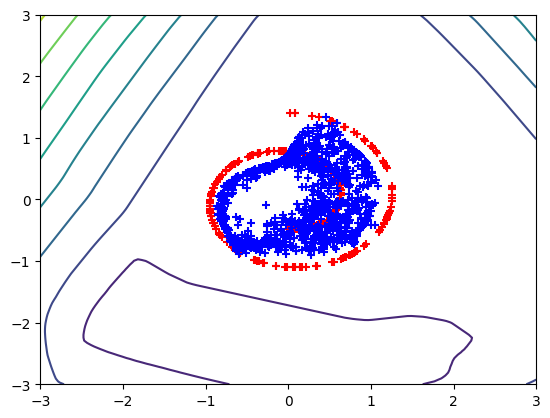

In [6]:
N_points_G=1000
true_data=Data_gen(batch_size)

generate_image(true_data,MLP,N_points_G)

In [5]:
def generate_image(true_dist,MLP,N_points_G):
    
    N_p = 128
    M = 3

    points = np.zeros([N_p, N_p, 2], dtype='float32')
    points[:, :, 0] = np.linspace(-M, M, N_p)[:, None]
    points[:, :, 1] = np.linspace(-M, M, N_p)[None, :]
    points = points.reshape((-1, 2))
    
    with torch.no_grad():
        
        points_v=torch.tensor(points,device=device)

        disc_map = MLP.Forward_Discriminator(points_v).cpu().numpy()

        noise_v = torch.randn([N_points_G, 2],device=device)

        samples = MLP.Forward_Generator(noise_v).cpu().numpy()

    plt.clf()
    
    true_dist=true_dist.detach().to('cpu').numpy()
    
    x = y = np.linspace(-M, M, N_p)
    plt.contour(x, y, disc_map.reshape((len(x), len(y))).transpose())

    plt.scatter(true_dist[:, 0], true_dist[:, 1], c='red', marker='+')  # true data
    plt.scatter(samples[:, 0], samples[:, 1], c='blue', marker='+')  # fake sample